# Week 4 - Word Embeddings

This week, we build on last week's topic modeling techniques by taking a text corpus we have developed, specifying an underlying number of dimensions, and training a model with a neural network auto-encoder (one of Google's word2vec  algorithms) that best describes corpus words in their local linguistic contexts, and exploring their locations in the resulting space to learn about the discursive culture that produced them. Documents here are represented as densely indexed locations in dimensions, rather than sparse mixtures of topics (as in LDA topic modeling), so that distances between those documents (and words) are consistently superior, though they require the full vector of dimension loadings (rather than just a few selected topic loadings) to describe. We will explore these spaces to understand complex, semantic relationships between words, index documents with descriptive words, identify the likelihood that a given document would have been produced by a given vector model, and explore how semantic categories can help us understand the cultures that produced them.

For this notebook we will be using the following packages

In [1]:
#Special module written for this class
#This provides access to data and to helper functions from previous weeks
#Make sure you update it before starting this notebook
import lucem_illud #pip install -U git+git://github.com/Computational-Content-Analysis-2018/lucem_illud.git

#All these packages need to be installed from pip
import gensim#For word2vec, etc
import requests #For downloading our datasets
import nltk #For stop words and stemmers
import numpy as np #For arrays
import pandas #Gives us DataFrames
import matplotlib.pyplot as plt #For graphics
import seaborn #Makes the graphics look nicer
import sklearn.metrics.pairwise #For cosine similarity
import sklearn.manifold #For T-SNE
import sklearn.decomposition #For PCA

#gensim uses a couple of deprecated features
#we can't do anything about them so lets ignore them 
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning) 

#This 'magic' command makes the plots work better
#in the notebook, don't use it outside of a notebook.
#Also you can ignore the warning
%matplotlib inline

import os #For looking through files
import os.path #For managing file paths

# Getting our corpora

Instead of downloading our corpora, we have download them in advance; a subset of the [senate press releases](https://github.com/lintool/GrimmerSenatePressReleases) are in `grimmerPressReleases`. We will load them into a DataFrame, using a function from a couple weeks ago `loadTextDirectory`:

In [2]:
kennedyDF = lucem_illud.loadTextDirectory('../data/grimmerPressReleases/Kennedy/')
kennedyDF[:5]

,text
01Apr2005Kennedy14.txt,FOR IMMEDIATE RELEASE FOR IMMEDIATE...
01Aug2005Kennedy12.txt,FOR IMMEDIATE RELEASE FOR IMMEDIATE...
01Aug2006Kennedy10.txt,FOR IMMEDIATE RELEASE FOR IMMEDIATE ...
01Aug2006Kennedy11.txt,FOR IMMEDIATE RELEASE FOR IMMEDIATE ...
01Aug2006Kennedy12.txt,FOR IMMEDIATE RELEASE FOR IMMEDIATE ...


This gets us one Senator's data, but with no metadata, we can add a category column with a simple command:

In [3]:
kennedyDF['category'] = 'Kennedy'
kennedyDF[:5]

,text,category
01Apr2005Kennedy14.txt,FOR IMMEDIATE RELEASE FOR IMMEDIATE...,Kennedy
01Aug2005Kennedy12.txt,FOR IMMEDIATE RELEASE FOR IMMEDIATE...,Kennedy
01Aug2006Kennedy10.txt,FOR IMMEDIATE RELEASE FOR IMMEDIATE ...,Kennedy
01Aug2006Kennedy11.txt,FOR IMMEDIATE RELEASE FOR IMMEDIATE ...,Kennedy
01Aug2006Kennedy12.txt,FOR IMMEDIATE RELEASE FOR IMMEDIATE ...,Kennedy


We also will be wanting to load all the senators so we will need to loop over all the directories

In [4]:
dataDir = '../data/grimmerPressReleases'

senReleasesDF = pandas.DataFrame()

for senatorDir in (file for file in os.scandir(dataDir) if not file.name.startswith('.') and file.is_dir()):
    senDF = lucem_illud.loadTextDirectory(senatorDir.path)
    senDF['category'] = senatorDir.name
    senReleasesDF = senReleasesDF.append(senDF, ignore_index = False)

senReleasesDF[:5]

,text,category
01Apr2005Kennedy14.txt,FOR IMMEDIATE RELEASE FOR IMMEDIATE...,Kennedy
01Aug2005Kennedy12.txt,FOR IMMEDIATE RELEASE FOR IMMEDIATE...,Kennedy
01Aug2006Kennedy10.txt,FOR IMMEDIATE RELEASE FOR IMMEDIATE ...,Kennedy
01Aug2006Kennedy11.txt,FOR IMMEDIATE RELEASE FOR IMMEDIATE ...,Kennedy
01Aug2006Kennedy12.txt,FOR IMMEDIATE RELEASE FOR IMMEDIATE ...,Kennedy


We also want to remove stop words and stem. Tokenizing requires two steps. Word2Vec needs to retain the sentence structure so as to capture a "continuous bag of words (CBOW)" and all of the skip-grams within a word window. The algorithm tries to preserve the distances induced by one of these two local structures. This is very different from clustering and LDA topic modeling which extract unordered words alone. As such, tokenizing is slightly more involved, but we can still use `lucem_illud`.

In [13]:
#Apply our functions, notice each row is a list of lists now
senReleasesDF['tokenized_sents'] = senReleasesDF['text'].apply(lambda x: 
                                                               [nltk.word_tokenize(s) for s in nltk.sent_tokenize(x)])
senReleasesDF['normalized_sents'] = senReleasesDF['tokenized_sents'].apply(lambda x: 
                                                                           [lucem_illud.normalizeTokens(s, 
                                                                                           stopwordLst = lucem_illud.stop_words_basic, 
                                                                                           stemmer = None) 
                                                                            for s in x])

senReleasesDF[:5]

,text,category,tokenized_sents,normalized_sents
01Apr2005Kennedy14.txt,FOR IMMEDIATE RELEASE FOR IMMEDIATE...,Kennedy,"[[FOR, IMMEDIATE, RELEASE, FOR, IMMEDIATE, REL...","[[immediate, release, immediate, release, cont..."
01Aug2005Kennedy12.txt,FOR IMMEDIATE RELEASE FOR IMMEDIATE...,Kennedy,"[[FOR, IMMEDIATE, RELEASE, FOR, IMMEDIATE, REL...","[[immediate, release, immediate, release, cont..."
01Aug2006Kennedy10.txt,FOR IMMEDIATE RELEASE FOR IMMEDIATE ...,Kennedy,"[[FOR, IMMEDIATE, RELEASE, FOR, IMMEDIATE, REL...","[[immediate, release, immediate, release, wash..."
01Aug2006Kennedy11.txt,FOR IMMEDIATE RELEASE FOR IMMEDIATE ...,Kennedy,"[[FOR, IMMEDIATE, RELEASE, FOR, IMMEDIATE, REL...","[[immediate, release, immediate, release, wash..."
01Aug2006Kennedy12.txt,FOR IMMEDIATE RELEASE FOR IMMEDIATE ...,Kennedy,"[[FOR, IMMEDIATE, RELEASE, FOR, IMMEDIATE, REL...","[[immediate, release, immediate, release, cont..."


# Word2Vec

We will be using the gensim implementation of [Word2Vec](https://radimrehurek.com/gensim/models/word2vec.html#gensim.models.word2vec.Word2Vec).

To load our data, we give all the sentences to the trainer. We just need to add the words as a list of sentences:

In [14]:
senReleasesW2V = gensim.models.word2vec.Word2Vec(senReleasesDF['normalized_sents'].sum())

Inside the word2vec object, the words each have a vector. To access the vector directly, use the square braces (`__getitem__`) method:

In [17]:
print("A {} dimesional vector:".format(senReleasesW2V['president'].shape[0]))
senReleasesW2V['president']

A 100 dimesional vector:


array([ 3.5460165 ,  0.41809118,  1.004169  ,  2.3616884 , -2.162185  ,
        0.8893318 , -2.7756996 , -0.48604497, -1.5412647 , -2.4820752 ,
       -2.191929  , -1.2351776 , -1.1389152 ,  0.57342654, -0.30886894,
       -0.03516562,  0.583807  , -2.4935198 , -1.0236382 , -0.24789475,
        1.0060257 ,  1.6658496 ,  2.5120578 ,  1.500967  , -1.5576643 ,
       -0.26666456, -1.944093  ,  0.3130546 ,  0.6157188 ,  1.0982636 ,
       -0.22075763, -2.062883  ,  1.1328382 ,  0.6088256 , -1.2387737 ,
       -0.02631386, -0.922476  , -0.13127568, -3.336613  , -0.12158246,
        0.08792038,  0.30979073, -1.6543784 ,  1.6129528 , -1.936147  ,
        1.2040673 , -0.10706139, -0.7415347 , -1.5792537 ,  2.03609   ,
       -0.14990991, -0.3349012 , -2.5287454 , -1.3846538 , -0.8536681 ,
       -0.40615597,  0.34818816,  2.4238064 ,  1.1106794 ,  0.2966778 ,
        0.67986035, -1.5377877 ,  1.7259918 , -0.1161475 , -1.6125871 ,
        0.29024813,  0.55948836, -0.23153718, -0.7294885 , -0.05

If you want the full matrix, `syn0` stores all the vectors:

In [18]:
senReleasesW2V.wv.syn0

array([[ 0.3777849 ,  0.87496865,  2.0689359 , ...,  2.0689502 ,
         0.3220019 ,  0.6179193 ],
       [-1.5793123 , -0.5776124 ,  1.1648496 , ..., -1.3696319 ,
         1.8711114 , -0.6309839 ],
       [ 2.0315065 ,  0.30653602,  0.44131815, ...,  2.516168  ,
         1.3728797 ,  1.4435571 ],
       ...,
       [-0.02888496, -0.09518585, -0.00284636, ...,  0.04514617,
        -0.04286274,  0.08588338],
       [-0.00353373, -0.07759305, -0.01002607, ...,  0.07158931,
        -0.09959304,  0.12945753],
       [-0.03623074, -0.00643337,  0.03654654, ...,  0.05042213,
         0.00470641,  0.02529114]], dtype=float32)

Then, `index2word` lets you translate from the matrix to words

In [19]:
senReleasesW2V.wv.index2word[10]

'american'

Now we can look at a few things that come from the word vectors. The first is to find similar vectors (cosine similarity):

In [20]:
senReleasesW2V.most_similar('president')

[('administration', 0.7934373021125793),
 ('presidents', 0.7453551292419434),
 ('administrations', 0.6619491577148438),
 ('cheney', 0.6093978881835938),
 ('george', 0.6029247045516968),
 ('ronald', 0.5556784868240356),
 ('responds', 0.5381815433502197),
 ('quoting', 0.5368585586547852),
 ('lamont', 0.5256049036979675),
 ('rollback', 0.517457127571106)]

In [21]:
senReleasesW2V.most_similar('war')

[('wars', 0.692754328250885),
 ('disobedience', 0.6844347715377808),
 ('unresisted', 0.6612114906311035),
 ('quagmire', 0.643332302570343),
 ('afghanistan', 0.6303823590278625),
 ('battle', 0.6238477230072021),
 ('descending', 0.609258234500885),
 ('chaos', 0.5934416055679321),
 ('insurgency', 0.5839394330978394),
 ('ticking', 0.5721606016159058)]

Or we can get this directly (calculated slightly differently):

In [22]:
def cos_difference(embedding,word1,word2):
    return sklearn.metrics.pairwise.cosine_similarity(embedding[word1].reshape(1,-1),embedding[word2].reshape(1,-1))

In [23]:
cos_difference(senReleasesW2V, 'war', 'unwinnable')

array([[0.5036833]], dtype=float32)

We can also find which word least matches the others within a word set (cosine similarity):

In [25]:
senReleasesW2V.doesnt_match(['administration', 'administrations', 'presidents', 'president', 'washington'])

'washington'

Find which word best matches the result of a semantic *equation* (here, we seek the words whose vectors best fit the missing entry from the equation: **X + Y - Z = _**.

In [26]:
senReleasesW2V.most_similar(positive=['clinton', 'republican'], negative = ['democrat'])

[('vetoed', 0.661482572555542),
 ('blocked', 0.6428155899047852),
 ('signed', 0.6352421641349792),
 ('bush', 0.6306736469268799),
 ('proposing', 0.6280951499938965),
 ('veto', 0.6224663853645325),
 ('signature', 0.6206871271133423),
 ('signing', 0.6172686219215393),
 ('desk', 0.5976161956787109),
 ('bushs', 0.5917327404022217)]

Here we see that **Clinton + Republican - Democrat = Bush**. In other words, in this dataset and period, **Clinton** was to **Democrat** as **Bush** was to **Republican**. Whoah!

 But how do we argue that these are stable distances or associations?

## Establishing Credible or Confidence Intervals

### Boostrapping approach

We propose well-established bootstrapping and subsampling methods to nonparametrically demonstrate the stability and significance of word associations within our embedding model. These allow us to establish conservative confidence intervals to both (a) distances between words in a model and (b) projections of words onto an induced dimension (e.g., man-woman). If we assume that the texts (e.g., newspapers, books) underlying our word embedding model are observations drawn from an independent and identically distributed (i.i.d.) population of cultural observations, then bootstrapping allows us to estimate the variance of word distances and projections by measuring those properties through sampling the empirical distribution of texts with replacement (Efron and Tibshirani 1994; Efron 2003). Operationally, if we wanted to bootstrap a 90% confidence interval of a word-word distance or word-dimension projection, we would sample a corpus the same size as the original corpus, but with replacement, 20 times, estimate word embedding models on each sample. Then we take the 2nd order (2nd smallest) statistic $s_{(2)}$--either distance or projection--as our confidence interval’s lower bound, and 19th order statistic $s_{(19)}$ as its upper bound. The distance between $s_{(2)}$ and $s_{(19)}$ across 20 bootstrap samples span the 5th to the 95th percentiles of the statistic’s variance, bounding the 90th confidence interval. A 95% confidence interval would span $s_{(2)}$ and $s_{(39)}$ in word embedding distances or projections estimated on 40 bootstrap samples of a corpus, tracing the 2.5th to 97.5th percentiles. 

In [31]:
estimatesB=[]
for x in range(20):
    senReleasesW2VB = gensim.models.word2vec.Word2Vec(senReleasesDF['normalized_sents'].sample(frac=1.0, replace=True).sum())
    try:
        estimatesB.append(cos_difference(senReleasesW2VB, 'war', 'unwinnable')[0,0])
    except KeyError:
        #Missing one of the words from the vocab
        pass
                                                      
estimatesB.sort()         
estimatesB

[0.2169547,
 0.37356764,
 0.37543947,
 0.3982813,
 0.40818596,
 0.43098342,
 0.45750836,
 0.4729581,
 0.49606565,
 0.5220706,
 0.52899224,
 0.5637557,
 0.6569015]

In [32]:
print("The 90% confidence interval for the cosine distance between war and unwinnable is:\n",estimatesB[1], estimatesB[-2])

The 90% confidence interval for the cosine distance between war and unwinnable is:
 0.37356764 0.5637557


### Subsampling approach

If the corpus is large, then we may take a subsampling approach, which randomly partitions the corpus into non-overlapping samples, then estimates the word-embedding models on these subsets and calculates confidence intervals as a function of the empirical distribution of distance or projection statistics and number of texts in the subsample (Politis and Romano 1997). Subsampling requires the same i.i.d. assumption as the bootrap (Politis and Romano 1992; Politis and Romano 1994). For 90% confidence intervals, we randomly partition the corpus into 20 subcorpora, then calculate $B^k=\sqrt{\tau_k}\left(s^k-\bar{s}\right)$ for each $k$th sample, where $k$ is the number of texts and $s^k$ is the embedding distance or projection for the $k$th sample, and $\bar{s}$ is the average statistic for all samples. The 90% confidence interval spans the 5th to 95th percentile variances, inscribed by $\bar{s}-\frac{B_{(19)}^k}{\sqrt{\tau}}$ and $\bar{s}-\frac{B_{(2)}^k}{\sqrt{\tau}}$, where $\tau$ the number of texts in the total corpus and $s$ is the average statistic across all subsamples. As with bootrapping, a 95% confidence interval would require 40 subsamples; a 99% confidence would require 200 (.5th to 99.5th percentiles).

In [139]:
n_samples = 10
sample_indices = np.random.randint(0,n_samples,(len(senReleasesDF),))

s_k =np.array([])
tau_k=np.array([])

for i in range(n_samples):
    sample_w2v = gensim.models.word2vec.Word2Vec(senReleasesDF[sample_indices == i]['normalized_sents'].sum())
    try:
        #Need to use words present in most samples
        s_k = np.append(s_k, cos_difference(sample_w2v, 'war', 'responsibility')[0,0])
    except KeyError:
        pass
    else:
        tau_k = np.append(tau_k, len(senReleasesDF[sample_indices == i]))

print(s_k)
print(tau_k)

tau = tau_k.sum()
s = s_k.mean()
B_k = np.sqrt(tau_k) * s_k-s_k.mean()

[0.99194902 0.95876276 0.99397326 0.98815084 0.94590795 0.97577226
 0.99194419 0.99583137 0.90060079 0.96788305]
[405. 401. 389. 384. 422. 352. 405. 399. 376. 371.]


In [140]:
print("The 90% confidence interval for the cosine distance between war and responsibility is:\n",s-B_k[-2]/np.sqrt(tau), s-B_k[1]/np.sqrt(tau))

The 90% confidence interval for the cosine distance between war and responsibility is:
 0.7071260051586976 0.6793434082216518


We can also save the vectors for later use:

In [36]:
senReleasesW2V.save("senpressreleasesWORD2Vec.mm")
#Load with senReleasesW2V = gensim.models.word2vec.Word2Vec.load('senpressreleasesWORD2Vec.mm')

## Visualize

We can also use dimension reduction to visulize the vectors. We will start by selecting a subset we want to plot. Let's look at the top words from the set:

In [37]:
numWords = 150
targetWords = senReleasesW2V.wv.index2word[:numWords]

We can then extract their vectors and create our own smaller matrix that preserved the distances from the original:

In [38]:
wordsSubMatrix = []
for word in targetWords:
    wordsSubMatrix.append(senReleasesW2V[word])
wordsSubMatrix = np.array(wordsSubMatrix)
wordsSubMatrix

array([[ 0.3777849 ,  0.87496865,  2.0689359 , ...,  2.0689502 ,
         0.3220019 ,  0.6179193 ],
       [-1.5793123 , -0.5776124 ,  1.1648496 , ..., -1.3696319 ,
         1.8711114 , -0.6309839 ],
       [ 2.0315065 ,  0.30653602,  0.44131815, ...,  2.516168  ,
         1.3728797 ,  1.4435571 ],
       ...,
       [-2.2403295 , -1.5251727 ,  0.4827413 , ..., -1.4645983 ,
        -2.2096786 ,  0.70928687],
       [ 0.53037655, -0.7792348 , -1.1864738 , ...,  0.4179504 ,
        -0.17344733,  1.2693027 ],
       [-0.48476684, -1.1274242 , -1.4650321 , ..., -0.9106411 ,
         1.2983727 , -0.35903326]], dtype=float32)

Then we can use PCA to reduce the dimesions (e.g., to 50), and [T-SNE](https://en.wikipedia.org/wiki/T-distributed_stochastic_neighbor_embedding) to project them down to the two we will visualize. We note that this is nondeterministic process, and so you can repeat and achieve alternative projectsions/visualizations of the words:

In [39]:
pcaWords = sklearn.decomposition.PCA(n_components = 50).fit(wordsSubMatrix)
reducedPCA_data = pcaWords.transform(wordsSubMatrix)
#T-SNE is theoretically better, but you should experiment
tsneWords = sklearn.manifold.TSNE(n_components = 2, early_exaggeration = 25).fit_transform(reducedPCA_data)

We now can plot the points

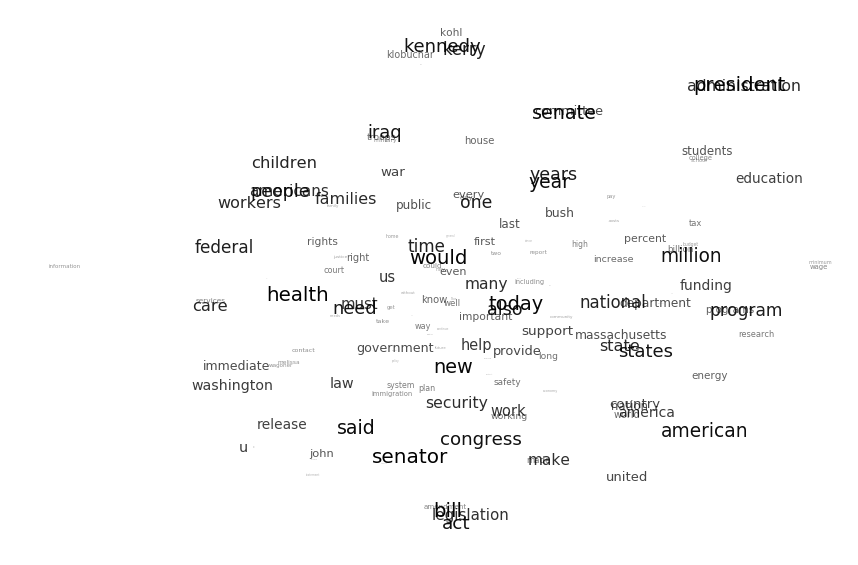

In [40]:
fig = plt.figure(figsize = (15,10))
ax = fig.add_subplot(111)
ax.set_frame_on(False)
plt.scatter(tsneWords[:, 0], tsneWords[:, 1], alpha = 0)#Making the points invisible 
for i, word in enumerate(targetWords):
    ax.annotate(word, 
                (tsneWords[:, 0][i],tsneWords[:, 1][i]), 
                size =  20 * (numWords - i) / numWords, 
                alpha = .8 * (numWords - i) / numWords + .2)
plt.xticks(())
plt.yticks(())
plt.show()

My visualization above puts ``iraq`` next to ``time`` and ``bill`` near ``help``. <img src='../data/examplewordcloud.svg'>

What if a new senator come along with whose names starts with K? Could we analyse their releases too without rerunning the entire embedding? Lets try with Cardin in `../data/grimmerPressReleases_extra/Cardin`. First we need to load and proccess the releases:

In [41]:
cardinDF = lucem_illud.loadTextDirectory('../data/grimmerPressReleases_extra/Cardin')
cardinDF['category'] = 'Cardin'

cardinDF['tokenized_sents'] = cardinDF['text'].apply(lambda x: 
                                                               [nltk.word_tokenize(s) for s in nltk.sent_tokenize(x)])
cardinDF['normalized_sents'] = cardinDF['tokenized_sents'].apply(lambda x: 
                                                                           [lucem_illud.normalizeTokens(s, 
                                                                                           stopwordLst = lucem_illud.stop_words_basic, 
                                                                                           stemmer = None) 
                                                                            for s in x])

cardinDF[:10]

,text,category,tokenized_sents,normalized_sents
01Aug2007Cardin156.txt,...,Cardin,"[[CARDIN, MIKULSKI, PRAISES, PASSAGE, OF, STRO...","[[cardin, mikulski, praises, passage, strong, ..."
01Feb2007Cardin297.txt,...,Cardin,"[[CARDIN, VOTES, TO, INCREASE, MINIMUM, WAGE, ...","[[cardin, votes, increase, minimum, wage, pay,..."
01Feb2007Cardin298.txt,...,Cardin,"[[S, 453, SEN, CARDIN, CO, SPONSORS, BILL, TO,...","[[sen, cardin, co, sponsors, bill, protect, vo..."
01Feb2007Cardin299.txt,...,Cardin,"[[S, 450, CARDIN, INTRODUCES, BILL, TO, ELIMIN...","[[cardin, introduces, bill, eliminate, arbitra..."
01Jun2007Cardin199.txt,...,Cardin,"[[CARDIN, MIKULSKI, ANNOUNCE, 7, 3, MILLION, F...","[[cardin, mikulski, announce, million, hagerst..."
01Jun2007Cardin200.txt,...,Cardin,"[[CARDIN, MIKULSKI, ANNOUNCE, 4, 6, MILLION, F...","[[cardin, mikulski, announce, million, salisbu..."
01Mar2007Cardin279.txt,...,Cardin,"[[SEN, CARDIN, FIGHTS, TO, IMPROVE, SECURITY, ...","[[sen, cardin, fights, improve, security, amer..."
01Mar2007Cardin280.txt,...,Cardin,"[[CARDIN, MIKULSKI, ANNOUNCE, 35, 000, FOR, WE...","[[cardin, mikulski, announce, western, marylan..."
01May2007Cardin228.txt,...,Cardin,"[[STATEMENT, BY, U, S, SENATOR, BENJAMIN, L, C...","[[statement, u, senator, benjamin, l, cardin, ..."
01May2007Cardin229.txt,...,Cardin,"[[CARDIN, TELLS, THE, AG, COMMITTEE, THAT, THE...","[[cardin, tells, ag, committee, farm, bill, co..."


We can now merge Cardin's releases with the rest. This can update all the weights in *w2v* model, so be careful.

In [42]:
#This is using a newer API so we have to tell it a little bit more for it to work right
senReleasesW2V.build_vocab(cardinDF['normalized_sents'].sum(), update=True)
senReleasesW2V.train(cardinDF['normalized_sents'].sum(), 
                     total_examples=senReleasesW2V.corpus_count, 
                     epochs=senReleasesW2V.iter)
senReleasesW2V.save("senpressreleasesWORD2Vec_new.mm")

As the model is updated by this, we need to load our old copy to do a comparison.

In [43]:
senReleasesW2V_old = gensim.models.word2vec.Word2Vec.load('senpressreleasesWORD2Vec.mm')

In [44]:
print("A {} dimesional vector:".format(senReleasesW2V['president'].shape[0]))
senReleasesW2V['president'][:10]

A 100 dimesional vector:


array([ 3.3056014 ,  0.758792  ,  1.5243504 ,  2.4831243 , -2.4748645 ,
        0.91773814, -2.60475   , -0.64155287, -1.9403723 , -2.462215  ],
      dtype=float32)

In [45]:
print("A {} dimesional vector:".format(senReleasesW2V_old['president'].shape[0]))
senReleasesW2V_old['president'][:10]

A 100 dimesional vector:


array([ 3.5460165 ,  0.41809118,  1.004169  ,  2.3616884 , -2.162185  ,
        0.8893318 , -2.7756996 , -0.48604497, -1.5412647 , -2.4820752 ],
      dtype=float32)

In [46]:
(senReleasesW2V_old['president'] - senReleasesW2V['president'])[:10]

array([ 0.2404151 , -0.3407008 , -0.5201814 , -0.12143588,  0.31267953,
       -0.02840632, -0.1709497 ,  0.15550789,  0.3991077 , -0.01986027],
      dtype=float32)

As you can see the vector for 'president' has changed a little bit and the word cloud should also be a bit different too

In [47]:
pcaWords = sklearn.decomposition.PCA(n_components = 50).fit(wordsSubMatrix)
reducedPCA_data = pcaWords.transform(wordsSubMatrix)
#T-SNE is theoretically better, but you should experiment
tsneWords = sklearn.manifold.TSNE(n_components = 2, early_exaggeration = 25).fit_transform(reducedPCA_data)

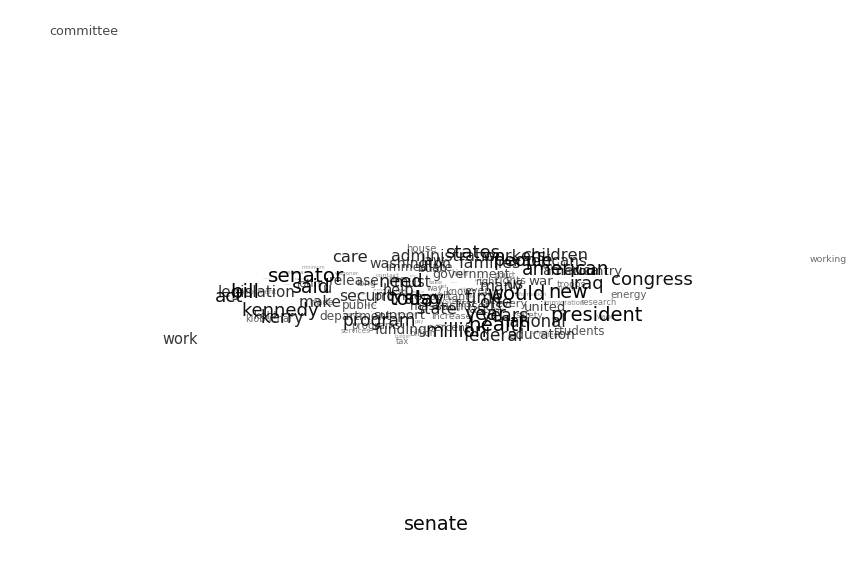

In [48]:
fig = plt.figure(figsize = (15,10))
ax = fig.add_subplot(111)
ax.set_frame_on(False)
plt.scatter(tsneWords[:, 0], tsneWords[:, 1], alpha = 0)#Making the points invisible 
for i, word in enumerate(targetWords):
    ax.annotate(word, 
                (tsneWords[:, 0][i],tsneWords[:, 1][i]), 
                size =  20 * (numWords - i) / numWords, 
                alpha = .8 * (numWords - i) / numWords + .2)
plt.xticks(())
plt.yticks(())
plt.show()

Another thing to consider in training is how we know that our parameters for the model are correct. We can do this by looking at the training loss of the model. Let's start by training a new model, but this time we will expose most of the options and train it one epoch at a time. Look [here](https://radimrehurek.com/gensim/models/word2vec.html#gensim.models.word2vec.Word2Vec) for more detail: 

In [51]:
senReleasesW2V_loss = gensim.models.word2vec.Word2Vec(size = 100, #dimensions
                                                      alpha=0.025,
                                                      window=5,
                                                      min_count=5,
                                                      hs=0,  #hierarchical softmax toggle
                                                      compute_loss = True,
                                                     )
senReleasesW2V_loss.build_vocab(senReleasesDF['normalized_sents'].sum())
senReleasesW2V_loss.train(senReleasesDF['normalized_sents'].sum(), 
                     total_examples=senReleasesW2V.corpus_count, 
                     epochs=1, #This the running_training_loss is a total so we have to do 1 epoch at a time
                    )
#Using a list so we can capture every epoch
losses = [senReleasesW2V_loss.running_training_loss]
losses[0]

1942081.5

Now we have the training loss and can optimize training to minimize it.

In [52]:
for i in range(19):
    senReleasesW2V_loss.train(senReleasesDF['normalized_sents'].sum(), 
                     total_examples=senReleasesW2V.corpus_count, 
                     epochs=1,
                             )
    losses.append(senReleasesW2V_loss.running_training_loss)
    print("Done epoch {}".format(i + 2), end = '\r')

Lets plot the loss vs epoch

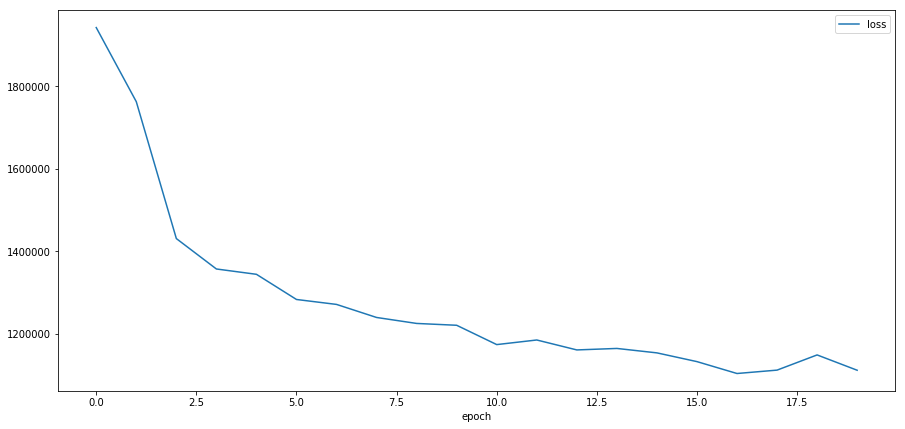

In [53]:
lossesDF = pandas.DataFrame({'loss' : losses, 'epoch' : range(len(losses))})
lossesDF.plot(y = 'loss', x = 'epoch', logy=False, figsize=(15, 7))
plt.show()

You should see that the loss is almost monotonic, but that the rate decreases as epoch increases. Since we are testing on our training data monotonicity is a common result and we must try to avoid over fitting. A simple way to do this is to stop training when there is significant change in the rate of decrease. In this run, that looks to be approximately 8 or 9. If we were to do another analysis, we might use an `iter=9` instead of the default 5.

Even more culturally interesting is how many dimensions are required to achieve an optimal embedding. The use of words in complex ways and contradictory contexts will require more dimensions to represent them with integrity. For example, if one word, $w_a$, is "nearby" $w_b$, but $w_b$ is not near the other words beside $w_a$, then a new dimension will be required for the two words to be uniquely together. 

In [54]:
losses_dims=[]

for d in [50,100,150,200,250,300,350,400,450,500, 550, 600, 650, 700, 750]:
    senReleasesW2V_loss_dims = gensim.models.word2vec.Word2Vec(size = d, #dimensions
                                                      alpha=0.025,
                                                      window=5,
                                                      min_count=5,
                                                      hs=0,  #hierarchical softmax toggle
                                                      compute_loss = True,
                                                     )
    senReleasesW2V_loss_dims.build_vocab(senReleasesDF['normalized_sents'].sum())
    senReleasesW2V_loss_dims.train(senReleasesDF['normalized_sents'].sum(), 
                     total_examples=senReleasesW2V.corpus_count, 
                     epochs=7, #This the running_training_loss is a total so we have to do 1 epoch at a time
                    )
    senReleasesW2V_loss_dims.train(senReleasesDF['normalized_sents'].sum(), 
                     total_examples=senReleasesW2V.corpus_count, 
                     epochs=1, #This the running_training_loss is a total so we have to do 1 epoch at a time
                    )
    
    losses_dims.append(senReleasesW2V_loss_dims.running_training_loss/(10+d*10))

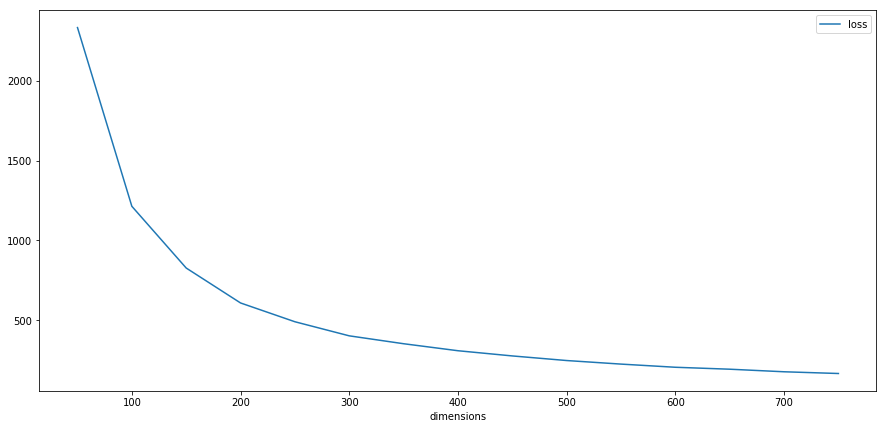

In [55]:
losses_dimsDF = pandas.DataFrame({'loss' : losses_dims, 'dimensions' : [50,100,150,200,250,300,350,400,450,500,550,600,650,700,750]})
losses_dimsDF.plot(y = 'loss', x = 'dimensions', logy=False, figsize=(15, 7))
plt.show()

This is a work in progress for Gensim, but its clear that most of the word distance variation is captured by 300 dimensions.

# Chinese examples

In [56]:
model=gensim.models.Word2Vec.load('../data/1992embeddings_hs_new3.sg')

## analogy

King+man-Queen? A few examples based on a corpus of Chinese news. 

First, location analogy: **province -> capital**

In [57]:
mm = model.most_similar(positive=[u'长沙',u'陕西'], negative=[u'湖南']) # Changsha + Shaanxi - Hunan
for m in mm:
    print(m[0],m[1])
    print("Xi'an")
    break

西安 0.36609965562820435
Xi'an


In [58]:
mm = model.most_similar(positive=[u'广州',u'湖北'], negative=[u'广东']) # Guangzhou + Hubei - Guangdong
for m in mm:
    print(m[0],m[1])
    print("Wuhan")
    break

武汉 0.3677000403404236
Wuhan


Second, location analogy: **country -> capital**

In [59]:
mm = model.most_similar(positive=[u'东京',u'美国'], negative=[u'日本']) # Tokyo + US - Japan
for m in mm:
    print(m[0],m[1])
    print("(Washington DC)")
    break

华盛顿 0.508813738822937
(Washington DC)


## similar words

In [60]:
word = u'社会主义'  #socialism
ss = model.similar_by_word(word,topn=10)
print("the most similar words to " + word + " is: ")
for s in ss:
    print(s[0])
print("")

the most similar words to 社会主义 is: 
特色
市场经济
理论
建设
改革开放
马克思主义
党
经济体制
基本路线
现代化



In [61]:
word = u'玉米'  # corn
ss = model.similar_by_word(word,topn=10)
print("the most similar words to " + word + " is: ")
for s in ss:
    print(s[0])
print("")

the most similar words to 玉米 is: 
小麦
水稻
作物
棉花
新品种
杂交
大豆
增产
栽培
农作物



## <span style="color:red">*Exercise 1*</span>

<span style="color:red">Construct cells immediately below this that build a word2vec model with your corpus. Interrogate word relationships in the resulting space, including estimating 90% confidence intervals for specific word cosine distances of interest. Plot a subset of your words. What do these word relationships reveal about the *social* and *cultural game* underlying your corpus? What was surprising--what violated your prior understanding of the corpus? What was expected--what confirmed your knowledge about this domain?

Gender stereotyping has been an inherent problem in the entertainment landscape. According to some of the researches conducted by [Geena Davis Institute](https://seejane.org/), female characters who are lucky enough to garner speaking roles tend to be highly stereotyped and the gender inequality on screen has remained largely unchanged and unchecked in the past six decades. To see if we can observe similar patterns by Word Embedding moethods, I collected the plot summaries of American films released from 2007 to 2017. The data is collected from [IMDB](http://www.imdb.com/) and most plot summaries are generated by users but some are from production companies.

In [62]:
np.random.seed(1234)

In [73]:
plot = pandas.read_csv('plot.csv')
plot[1500:1510]

,id,title,year,plot
1500,3973202,Light and the Sufferer,2007,Realism and fantasy collide in Jonathan Lethem...
1501,3973697,Lights Camera Dead,2007,So you want to make a movie. You tell yourself...
1502,3974036,Like a Glove,2007,Robin Darjeeling and Mike Jones are two profes...
1503,3974923,Lily,2007,"""Lily"" is an atmospheric and suspenseful tale ..."
1504,3975135,Limbo,2007,Small stories mix to paint a vivid picture of ...
1505,3975681,"Linda, as in Beautiful",2007,Linda was born into a family of children durin...
1506,3976248,Linus,2007,During a typical morning in New York's East Vi...
1507,3976451,Lions for Lambs,2007,Three stories told simultaneous in ninety minu...
1508,3976468,Lions' Den,2007,A group of old friends are hanging at one of t...
1509,3976905,Lisa's Last Chance,2007,"Lisa, a troubled young woman plagued by strang..."


In [74]:
# Tokenize text, remove stop words and stem
plot['tokenized_sents'] = plot['plot'].apply(lambda x: [nltk.word_tokenize(s) for s in nltk.sent_tokenize(x)])
stopwords = list(set(lucem_illud.stop_words_basic) - set(['he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself']))
plot['normalized_sents'] = plot['tokenized_sents'].apply(lambda x: [lucem_illud.normalizeTokens(s, 
                                                                                                stopwordLst = stopwords, 
                                                                                                stemmer = None)
                                                         for s in x])

plot[1500:1510]

,id,title,year,plot,tokenized_sents,normalized_sents
1500,3973202,Light and the Sufferer,2007,Realism and fantasy collide in Jonathan Lethem...,"[[Realism, and, fantasy, collide, in, Jonathan...","[[realism, fantasy, collide, jonathan, lethem,..."
1501,3973697,Lights Camera Dead,2007,So you want to make a movie. You tell yourself...,"[[So, you, want, to, make, a, movie, .], [You,...","[[want, make, movie], [tell, time, time, write..."
1502,3974036,Like a Glove,2007,Robin Darjeeling and Mike Jones are two profes...,"[[Robin, Darjeeling, and, Mike, Jones, are, tw...","[[robin, darjeeling, mike, jones, two, profess..."
1503,3974923,Lily,2007,"""Lily"" is an atmospheric and suspenseful tale ...","[[``, Lily, '', is, an, atmospheric, and, susp...","[[lily, atmospheric, suspenseful, tale, love, ..."
1504,3975135,Limbo,2007,Small stories mix to paint a vivid picture of ...,"[[Small, stories, mix, to, paint, a, vivid, pi...","[[small, stories, mix, paint, vivid, picture, ..."
1505,3975681,"Linda, as in Beautiful",2007,Linda was born into a family of children durin...,"[[Linda, was, born, into, a, family, of, child...","[[linda, born, family, children, early], [watc..."
1506,3976248,Linus,2007,During a typical morning in New York's East Vi...,"[[During, a, typical, morning, in, New, York, ...","[[typical, morning, new, york, east, village, ..."
1507,3976451,Lions for Lambs,2007,Three stories told simultaneous in ninety minu...,"[[Three, stories, told, simultaneous, in, nine...","[[three, stories, told, simultaneous, ninety, ..."
1508,3976468,Lions' Den,2007,A group of old friends are hanging at one of t...,"[[A, group, of, old, friends, are, hanging, at...","[[group, old, friends, hanging, one, houses, e..."
1509,3976905,Lisa's Last Chance,2007,"Lisa, a troubled young woman plagued by strang...","[[Lisa, ,, a, troubled, young, woman, plagued,...","[[lisa, troubled, young, woman, plagued, stran..."


In [75]:
# Add the words as a list of sentences
plot_sents = plot['normalized_sents'].sum()

In [78]:
# Build a word2vec model
plotW2V = gensim.models.word2vec.Word2Vec(plot_sents)

In [354]:
# Save the vectors
plotW2V.save("plotW2V.mm")

Let's explore some of the word relationships in the resulting space and see if there are some gender inequality issues present.

In [86]:
plotW2V.most_similar('he')

[('instead', 0.6085127592086792),
 ('someone', 0.5890056490898132),
 ('she', 0.5815449953079224),
 ('his', 0.569932758808136),
 ('finally', 0.5628989934921265),
 ('nobody', 0.554957926273346),
 ('jack', 0.5401062965393066),
 ('him', 0.5286221504211426),
 ('anyone', 0.5272783041000366),
 ('everybody', 0.5133979320526123)]

In [87]:
plotW2V.most_similar('she')

[('her', 0.7073326110839844),
 ('herself', 0.6499477624893188),
 ('he', 0.5815451145172119),
 ('alice', 0.5804457664489746),
 ('instead', 0.5671901702880859),
 ('someone', 0.5542104244232178),
 ('sara', 0.5259395837783813),
 ('finally', 0.5211862921714783),
 ('boyfriend', 0.5089362859725952),
 ('lena', 0.5065207481384277)]

It seems that "she" cares more about "herself" than "he" about "himself", which indicates that woman on screen are more self-conscious and sensitive than man. "he" is similar to "someone", "nobody", "anyone", "everybody", while "she" is only similar to "someone", which indicates that "he" is a more general pronoun for human while "she" is different from the crowd.

In [89]:
plotW2V.most_similar('man')

[('woman', 0.6458396911621094),
 ('boy', 0.6187288761138916),
 ('person', 0.5790902972221375),
 ('girl', 0.5190879106521606),
 ('teenager', 0.5146135687828064),
 ('guy', 0.5091687440872192),
 ('men', 0.5067042112350464),
 ('stranger', 0.4958260655403137),
 ('lady', 0.48096174001693726),
 ('drifter', 0.47911590337753296)]

In [90]:
plotW2V.most_similar('woman')

[('girl', 0.7411398887634277),
 ('lady', 0.661726713180542),
 ('man', 0.6458396315574646),
 ('teenager', 0.623715877532959),
 ('couple', 0.6063103675842285),
 ('stranger', 0.5848336815834045),
 ('person', 0.5827443599700928),
 ('prostitute', 0.579747200012207),
 ('daughter', 0.5614525079727173),
 ('boy', 0.5585840940475464)]

"woman" is most similar to "man" but other than "man", "girl" and "lady" are more similar to "woman", which indicates that "man" is more a representative of humans without specification of gender, while "woman" is a gendered concept. "woman" is similar to "couple" and "daughter" while "man" is not that similar to "couple" or "son", indicating that woman on screen is more often involved in a relationship or a family than man. "prostitute" is quite similar to "woman", which indicates the frequency of appearance of prostitutes in movies and the blemish of image of woman.

In [91]:
plotW2V.most_similar('him')

[('whatever', 0.5918275713920593),
 ('instead', 0.5756446719169617),
 ('someone', 0.5702896118164062),
 ('mistake', 0.5494906902313232),
 ('wo', 0.5472674369812012),
 ('pills', 0.5385191440582275),
 ('medication', 0.5357375144958496),
 ('unless', 0.5319199562072754),
 ('he', 0.5286222696304321),
 ('matters', 0.5188770294189453)]

In [94]:
plotW2V.most_similar('his')

[('he', 0.5699328184127808),
 ('him', 0.465472549200058),
 ('himself', 0.4553268849849701),
 ('jack', 0.44671985507011414),
 ('sam', 0.44433414936065674),
 ('jake', 0.43917417526245117),
 ('bury', 0.4374714493751526),
 ('eli', 0.43217700719833374),
 ('reconnect', 0.42257601022720337),
 ('deceased', 0.4203745126724243)]

In [92]:
plotW2V.most_similar('her')

[('she', 0.7073326110839844),
 ('herself', 0.6318990588188171),
 ('alice', 0.5626062154769897),
 ('abusive', 0.5358874797821045),
 ('baby', 0.5334232449531555),
 ('maggie', 0.5249161124229431),
 ('sara', 0.5214846134185791),
 ('angela', 0.5014844536781311),
 ('emily', 0.4996299147605896),
 ('sarah', 0.49897897243499756)]

"her" is similar to a couple of female names, while "him" or "his" is not that similar to male names besides "jack" and "jake", which indicates a strong reinforced image of woman wrapped in certain names. "her" is similar to "abusive", indicating an general abusive image of woman on screen.

In [95]:
plotW2V.most_similar('himself')

[('solace', 0.5979607105255127),
 ('herself', 0.5464167594909668),
 ('francoise', 0.5152555704116821),
 ('instead', 0.5026633143424988),
 ('he', 0.4853353500366211),
 ('jack', 0.474569171667099),
 ('his', 0.4553268849849701),
 ('suddenly', 0.44609034061431885),
 ('reason', 0.4419957995414734),
 ('comfort', 0.4344431459903717)]

In [96]:
plotW2V.most_similar('herself')

[('solace', 0.6840775012969971),
 ('she', 0.6499477624893188),
 ('her', 0.6318990588188171),
 ('comfort', 0.6177746057510376),
 ('instead', 0.5584439039230347),
 ('himself', 0.5464167594909668),
 ('companionship', 0.5183465480804443),
 ('alice', 0.508037805557251),
 ('padrig', 0.5059424638748169),
 ('francoise', 0.500732421875)]

"solace" and "comfort" is more similar to "herself" than "himself", indicating that woman on screen are more tender.

In [97]:
plotW2V.most_similar('husband')

[('boyfriend', 0.8161592483520508),
 ('fiancé', 0.8130121231079102),
 ('lover', 0.7965005040168762),
 ('fiance', 0.789196252822876),
 ('mother', 0.7875567674636841),
 ('daughter', 0.7702010869979858),
 ('grandmother', 0.7454313635826111),
 ('mom', 0.7361323237419128),
 ('stepfather', 0.7230997681617737),
 ('aunt', 0.7230936884880066)]

In [98]:
plotW2V.most_similar('wife')

[('girlfriend', 0.8411237001419067),
 ('fiancée', 0.7939515113830566),
 ('father', 0.7736597061157227),
 ('fiancé', 0.7606573104858398),
 ('fiance', 0.7377289533615112),
 ('daughter', 0.7364429235458374),
 ('mother', 0.7180256843566895),
 ('mom', 0.7142801284790039),
 ('lover', 0.7087486386299133),
 ('cousin', 0.7082852125167847)]

Both "husband" and "wife" is about relationship and family, but it is interesting to observe that "father" is not that similar to "husband", which indicates that the depiction of "husband" is more about relationship than in a family setting.

In [141]:
print('nurse-woman:', cos_difference(plotW2V, 'nurse', 'woman')[0][0])
print('nurse-man:', cos_difference(plotW2V, 'nurse', 'man')[0][0])
print('doctor-woman:', cos_difference(plotW2V, 'doctor', 'woman')[0][0])
print('doctor-man:', cos_difference(plotW2V, 'doctor', 'man')[0][0])
print('professor-woman:', cos_difference(plotW2V, 'professor', 'woman')[0][0])
print('professor-man:', cos_difference(plotW2V, 'professor', 'man')[0][0])
print('scientist-woman:', cos_difference(plotW2V, 'scientist', 'woman')[0][0])
print('scientist-man:', cos_difference(plotW2V, 'scientist', 'man')[0][0])
print('lawyer-woman:', cos_difference(plotW2V, 'lawyer', 'woman')[0][0])
print('lawyer-man:', cos_difference(plotW2V, 'lawyer', 'man')[0][0])
print('business-woman:', cos_difference(plotW2V, 'business', 'woman')[0][0])
print('business-man:', cos_difference(plotW2V, 'business', 'man')[0][0])
print('driver-woman:', cos_difference(plotW2V, 'driver', 'woman')[0][0])
print('driver-man:', cos_difference(plotW2V, 'driver', 'man')[0][0])

nurse-woman: 0.5216533
nurse-man: 0.24287237
doctor-woman: 0.37489873
doctor-man: 0.33185697
professor-woman: 0.10604274
professor-man: 0.08980471
scientist-woman: 0.21684948
scientist-man: 0.31676695
lawyer-woman: 0.3548103
lawyer-man: 0.3242365
business-woman: -0.091811225
business-man: 0.056392286
driver-woman: 0.26924303
driver-man: 0.35800377


As we can see, there are occupations much more similar to woman, such as nurse, and occupations much more similar to man, such as scientist, business man, driver. Thus there are some stereotypes about gendered occupational roles, and it should be more informative if we can spend the time to test all kinds of occupations.

In [350]:
def find_90CI_cos_difference(word1, word2, DF = plot):
    n_samples = 20
    sample_indices = np.random.randint(0, n_samples, (len(DF),))

    s_k = np.array([])
    tau_k = np.array([])

    for i in range(n_samples):
        sample_w2v = gensim.models.word2vec.Word2Vec(DF[sample_indices == i]['normalized_sents'].sum())
        try:
            #Need to use words present in most samples
            s_k = np.append(s_k, cos_difference(sample_w2v, word1, word2)[0,0])
        except KeyError:
            pass
        else:
            tau_k = np.append(tau_k, len(DF[sample_indices == i]))

    tau = tau_k.sum()
    s = s_k.mean()
    B_k = np.sqrt(tau_k) * s_k-s_k.mean()
    
    lower_bound = s-B_k[-2]/np.sqrt(tau)
    upper_bound = s-B_k[1]/np.sqrt(tau)
    
    return lower_bound, upper_bound

In [352]:
print('90% CI for the cosine distance between nurse and woman:', find_90CI_cos_difference('nurse', 'woman', plot))
print('90% CI for the cosine distance between nurse and man:', find_90CI_cos_difference('nurse', 'man', plot))
print('90% CI for the cosine distance between scientist and woman:', find_90CI_cos_difference('scientist', 'woman', plot))
print('90% CI for the cosine distance between scientist and man:', find_90CI_cos_difference('scientist', 'man', plot))
print('90% CI for the cosine distance between business and woman:', find_90CI_cos_difference('business', 'woman', plot))
print('90% CI for the cosine distance between business and man:', find_90CI_cos_difference('business', 'man', plot))
print('90% CI for the cosine distance between driver and woman:', find_90CI_cos_difference('driver', 'woman', plot))
print('90% CI for the cosine distance between driver and man:', find_90CI_cos_difference('driver', 'man', plot))

90% CI for the cosine distance between nurse and woman: (0.7813126974882679, 0.7803432102997452)
90% CI for the cosine distance between nurse and man: (0.7683583684009107, 0.7682686291835636)
90% CI for the cosine distance between scientist and woman: (0.7800115856629135, 0.7806169627100262)
90% CI for the cosine distance between scientist and man: (0.7769829998783837, 0.7766485451688094)
90% CI for the cosine distance between business and woman: (0.7784905804415064, 0.7838516133228843)
90% CI for the cosine distance between business and man: (0.7837498786020937, 0.7813891491588552)
90% CI for the cosine distance between driver and woman: (0.779596305895819, 0.7816733418439475)
90% CI for the cosine distance between driver and man: (0.7785253119821081, 0.7837448447557789)


It does not make sense that the CIs are so far away from the cos differences that we computed above and so similar to each other. Maybe there are something wrong with the smaple code.

In [148]:
plotW2V.most_similar(positive=['woman', 'pretty'], negative = ['man'])

[('smart', 0.7316969633102417),
 ('confident', 0.708824872970581),
 ('cute', 0.7006365060806274),
 ('attractive', 0.7005586624145508),
 ('attracted', 0.6736495494842529),
 ('charming', 0.6581969857215881),
 ('jenny', 0.656886100769043),
 ('nice', 0.634893536567688),
 ('hair', 0.6335693001747131),
 ('sweet', 0.6329323053359985)]

Woman wants "pretty" and man wants "smart". This sounds so typically stereotyped that woman cares about appearance and man cares about intelligence.

In [153]:
plotW2V.most_similar(positive=['woman', 'love'], negative = ['man'])

[('grace', 0.6206032037734985),
 ('romance', 0.5628785490989685),
 ('joy', 0.5246058702468872),
 ('affection', 0.507367730140686),
 ('friendship', 0.4848850965499878),
 ('feelings', 0.4826497435569763),
 ('longing', 0.4672941267490387),
 ('mutual', 0.4534757733345032),
 ('acceptance', 0.4533383846282959),
 ('romantic', 0.44798439741134644)]

Woman wants "love" and man wants "grace". This indicates that woman is more into love, emotion and feelings, while man is more into grace, pride, and esteem.

In [154]:
# visualize
numWords = 150
targetWords = plotW2V.wv.index2word[:numWords]

wordsSubMatrix = []
for word in targetWords:
    wordsSubMatrix.append(plotW2V[word])
wordsSubMatrix = np.array(wordsSubMatrix)

In [159]:
pcaWords = sklearn.decomposition.PCA(n_components = 50).fit(wordsSubMatrix)
reducedPCA_data = pcaWords.transform(wordsSubMatrix)
tsneWords = sklearn.manifold.TSNE(n_components = 2, early_exaggeration = 25).fit_transform(reducedPCA_data)

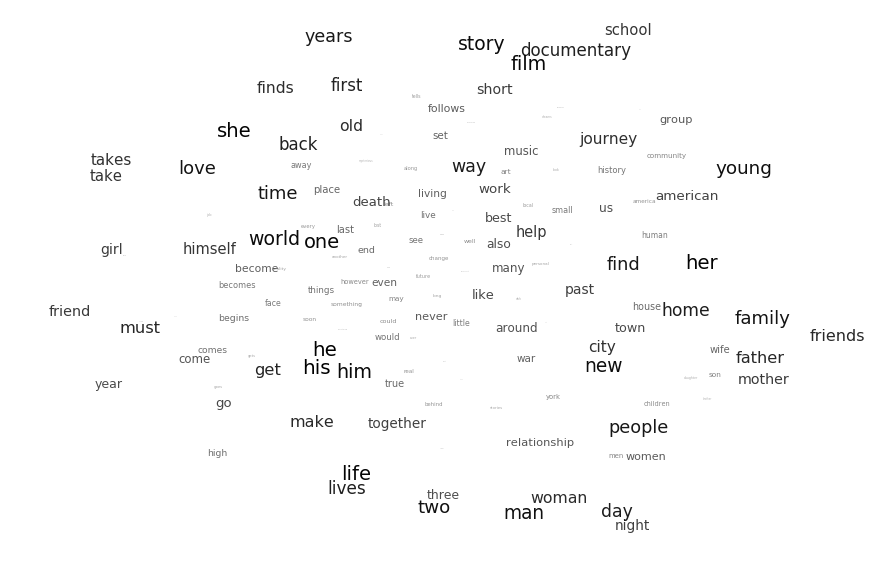

In [160]:
fig = plt.figure(figsize = (15,10))
ax = fig.add_subplot(111)
ax.set_frame_on(False)
plt.scatter(tsneWords[:, 0], tsneWords[:, 1], alpha = 0)# Making the points invisible 
for i, word in enumerate(targetWords):
    ax.annotate(word, 
                (tsneWords[:, 0][i],tsneWords[:, 1][i]), 
                size =  20 * (numWords - i) / numWords, 
                alpha = .8 * (numWords - i) / numWords + .2)
plt.xticks(())
plt.yticks(())
plt.show()

It is interesting to see how "her" is close to "home", "family", "friends", and "she" close to "love", which emphasizes the image of woman in family settings instead of in employment settings.

Based on the above analysis, we found many stereotyped images of woman on screen and it seems a topic that can be pursued further.

# Doc2Vec

Instead of just looking at just how words embed within in the space, we can look at how the different documents relate to each other within the space. First lets load our data--abstracts of most U.S. physics papers from the 1950s.

In [161]:
apsDF = pandas.read_csv('../data/APSabstracts1950s.csv', index_col = 0)
apsDF[:10]

,copyrightYear,doi,abstract
0,1950,10.1103/RevModPhys.22.221,A summarizing account is given of the research...
1,1951,10.1103/RevModPhys.23.147,New tables of coulomb functions are presented ...
2,1951,10.1103/RevModPhys.23.185,Ionization by electron impact in diatomic gase...
3,1951,10.1103/RevModPhys.23.203,It is shown that the conductivity in the ohmic...
4,1951,10.1103/RevModPhys.23.21,The factorization method is an operational pro...
5,1951,10.1103/RevModPhys.23.311,A brief account is given of Dyson's proof of t...
6,1951,10.1103/RevModPhys.23.315,A systematics is given of all transitions for ...
7,1951,10.1103/RevModPhys.23.322,A systematics of the -transitions of even A nu...
8,1951,10.1103/RevModPhys.23.328,The available experiments on the absorption sp...
9,1952,10.1103/RevModPhys.24.108,The classical theory of the dynamics of viscou...


We will load these as documents into Word2Vec, but first we need to normalize and pick some tags

In [162]:
keywords = ['photomagnetoelectric', 'quantum', 'boltzmann', 'proton', 'positron', 'feynman', 'classical', 'relativity']

In [163]:
apsDF['tokenized_words'] = apsDF['abstract'].apply(lambda x: nltk.word_tokenize(x))
apsDF['normalized_words'] = apsDF['tokenized_words'].apply(lambda x: lucem_illud.normalizeTokens(x, stopwordLst = lucem_illud.stop_words_basic, stemmer = None))

In [164]:
taggedDocs = []
for index, row in apsDF.iterrows():
    #Just doing a simple keyword assignment
    docKeywords = [s for s in keywords if s in row['normalized_words']]
    docKeywords.append(row['copyrightYear'])
    docKeywords.append(row['doi']) #This lets us extract individual documnets since doi's are unique
    taggedDocs.append(gensim.models.doc2vec.LabeledSentence(words = row['normalized_words'], tags = docKeywords))
apsDF['TaggedAbstracts'] = taggedDocs

In [184]:
apsDF.TaggedAbstracts[18]

LabeledSentence(words=['present', 'theories', 'magnetization', 'based', 'largely', 'energy', 'formulas', 'incomplete', 'rely', 'calculation', 'magnetization', 'work', 'absence', 'strain', 'strain', 'work', 'absence', 'magnetization', 'present', 'paper', 'summarizes', 'relates', 'magnetization', 'theory', 'calculation', 'already', 'published', 'elsewhere', 'magnetization', 'strain', 'assumed', 'start', 'present', 'simultaneously', 'furthermore', 'forces', 'calculated', 'directly', 'without', 'use', 'energy', 'arguments', 'properties', 'special', 'materials', 'considered', 'important', 'result', 'separation', 'force', 'part', 'body', 'magnetic', 'force', 'force', 'derivable', 'stresses', 'accomplished', 'one', 'way', 'theory', 'confirms', 'traditional', 'results', 'fluids', 'elastic', 'solids', 'yields', 'terms', 'present', 'formulas', 'traditional', 'theory', 'terms', 'may', 'important', 'magnetization', 'process', 'uniformly', 'magnetized', 'ellipsoid', 'lead', 'nonuniform', 'magnetost

Now we can train a Doc2Vec model:

In [167]:
apsD2V = gensim.models.doc2vec.Doc2Vec(apsDF['TaggedAbstracts'], size = 100) #Limiting to 100 dimensions

We can get vectors for the tags/documents, just as we did with words. Documents are actually the centroids (high dimensional average points) of their words. 

In [168]:
apsD2V.docvecs[1952]

array([ 1.5430495 , -1.1213387 ,  0.15285268, -0.39002323,  1.0230573 ,
       -0.10800017,  0.57866997,  0.03636144,  0.4273172 ,  0.6378815 ,
        1.1939092 ,  0.61656696,  0.6352726 , -0.37839428, -0.30618185,
       -0.4312941 ,  0.54573095, -1.089156  ,  0.67077875,  0.408222  ,
        0.28288737, -0.12707768, -0.14647943, -0.77206385,  0.87747365,
        0.713388  ,  0.30491444, -1.0459838 ,  0.11171173, -1.7560887 ,
       -2.1046238 , -0.16680725,  1.6474398 , -0.7637604 , -0.09005821,
       -1.0453063 , -0.02653909, -0.8002394 , -1.115936  ,  0.85199463,
       -1.7312446 , -1.6085752 ,  1.6053569 ,  0.17943548, -1.0860788 ,
        0.8319337 , -0.48872912,  0.21198131,  1.3282292 ,  1.3757097 ,
       -1.3149499 ,  0.5931777 , -0.5268895 , -1.8339082 , -0.49347448,
        0.6865628 , -0.42478094,  0.41794285,  0.54458606,  0.06772465,
        0.13571897,  0.0062857 ,  0.19448689,  0.39119762, -1.4427335 ,
        0.00663377, -0.28902426,  1.8568753 ,  0.26398593, -0.33

The words can still be accessed in the same way:

In [169]:
apsD2V['atom']

array([ 0.26804438, -1.1337256 ,  0.05869593, -0.08727724,  1.154145  ,
        0.825849  ,  0.00878443, -0.3377676 , -0.15234873,  0.41776657,
        0.41871747,  0.6526781 ,  0.7833653 ,  0.44951537,  0.525193  ,
        0.27496713,  0.95756227, -0.4134003 ,  0.20612502, -0.40033638,
        0.18765527, -0.51245475, -0.2929659 , -0.14372171, -0.03596746,
       -0.20018685,  0.3767332 , -1.0946081 ,  0.29958418, -0.30440682,
       -1.0615867 ,  0.03930689,  0.2845377 , -0.28362057, -0.20347212,
       -0.39629787,  0.36581412, -0.7826284 , -0.14799017, -0.46392962,
        0.17059726, -0.48918152,  0.8560931 ,  0.60965097,  0.21482529,
       -0.38712832,  0.596635  ,  1.1878642 , -0.08068628, -0.20658463,
       -0.5507061 ,  0.08456516, -0.3546545 , -0.12091089, -0.03145595,
        0.29284135, -0.71749294, -0.72402036,  0.24508992, -0.64128923,
        1.1303077 ,  0.4754942 , -0.03998147,  0.7992742 , -0.1695591 ,
       -0.7068051 ,  0.6384714 ,  0.46791866, -0.0121365 ,  0.30

We can still use the ``most_similar`` command to perform simple semantic equations:

In [170]:
apsD2V.most_similar(positive = ['atom','electrons'], negative = ['electron'], topn = 1)

[('atoms', 0.8002512454986572)]

This is interesting. **Electron** is to **electrons** as **atom** is to **atoms**. Another way to understand this, developed below is: **electrons - electron** induces a singular to plural dimension, so when we subtract **electron** from **atom** and add **electrons**, we get **atoms**! 

In [171]:
apsD2V.most_similar(positive = ['einstein','law'], negative = ['equation'], topn = 1)

[('distortions', 0.9484764337539673)]

In other words **Einstein** minus **equation** plus **law** equals **Meissner**--Walthur Meissner studied mechanical engineering and physics ... and was more likely to produce a "law" than a "equation", like the Meissner effect, the damping of the magnetic field in superconductors. If we built our word-embedding with a bigger corpus like the entire arXiv, a massive repository of physics preprints, we would see many more such relationships like **gravity - Newton + Einstein = relativity**.

We can also compute all of these *by hand*--explicitly wth vector algebra: 

In [172]:
sklearn.metrics.pairwise.cosine_similarity(apsD2V['electron'].reshape(1,-1), apsD2V['positron'].reshape(1,-1))
#We reorient the vectors with .reshape(1, -1) so that they can be computed without a warning in sklearn

array([[0.6025014]], dtype=float32)

In the doc2vec model, the documents have vectors just as the words do, so that we can compare documents with each other and also with words (similar to how a search engine locates a webpage with a query). First, we will calculate the distance between a word and documents in the dataset:

In [173]:
apsD2V.docvecs.most_similar([ apsD2V['electron'] ], topn=5 )

[('10.1103/PhysRev.112.812', 0.6446165442466736),
 ('10.1103/PhysRev.98.1584', 0.6360435485839844),
 ('10.1103/PhysRev.103.1202', 0.6264927983283997),
 ('10.1103/PhysRev.95.897', 0.6211022138595581),
 ('10.1103/PhysRev.86.41', 0.5981184840202332)]

If we search for the first of these on the web (these are doi codes), we find the following...a pretty good match:
<img src='../data/PhysRev.98.875.jpg'>

Now let's go the other way around and find words most similar to this document:

In [174]:
apsD2V.most_similar( [ apsD2V.docvecs['10.1103/PhysRev.98.875'] ], topn=5) 

[('amount', 0.7062056660652161),
 ('equal', 0.696540355682373),
 ('less', 0.6922513246536255),
 ('times', 0.6882939338684082),
 ('per', 0.6851367354393005)]

We can even look for documents most like a query composed of multiple words:

In [175]:
apsD2V.docvecs.most_similar([ apsD2V['electron']+apsD2V['positron']+apsD2V['neutron']], topn=5 )

[('10.1103/PhysRev.105.204', 0.7992915511131287),
 ('10.1103/PhysRev.89.1165', 0.7963807582855225),
 ('10.1103/PhysRev.109.1193', 0.7810815572738647),
 ('10.1103/PhysRev.105.1014', 0.7768859267234802),
 ('10.1103/PhysRev.85.461', 0.774574875831604)]

Now let's plot some words and documents against one another with a heatmap:

In [176]:
heatmapMatrix = []
for tagOuter in keywords:
    column = []
    tagVec = apsD2V.docvecs[tagOuter].reshape(1, -1)
    for tagInner in keywords:
        column.append(sklearn.metrics.pairwise.cosine_similarity(tagVec, apsD2V.docvecs[tagInner].reshape(1, -1))[0][0])
    heatmapMatrix.append(column)
heatmapMatrix = np.array(heatmapMatrix)

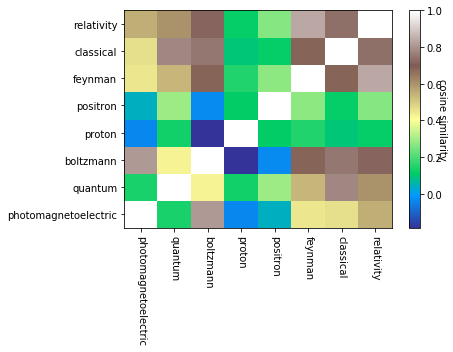

In [177]:
fig, ax = plt.subplots()
hmap = ax.pcolor(heatmapMatrix, cmap='terrain')
cbar = plt.colorbar(hmap)

cbar.set_label('cosine similarity', rotation=270)
a = ax.set_xticks(np.arange(heatmapMatrix.shape[1]) + 0.5, minor=False)
a = ax.set_yticks(np.arange(heatmapMatrix.shape[0]) + 0.5, minor=False)

a = ax.set_xticklabels(keywords, minor=False, rotation=270)
a = ax.set_yticklabels(keywords, minor=False)

Now let's look at a heatmap of similarities between the first ten documents in the corpus:

In [178]:
targetDocs = apsDF['doi'][:10]

heatmapMatrixD = []

for tagOuter in targetDocs:
    column = []
    tagVec = apsD2V.docvecs[tagOuter].reshape(1, -1)
    for tagInner in targetDocs:
        column.append(sklearn.metrics.pairwise.cosine_similarity(tagVec, apsD2V.docvecs[tagInner].reshape(1, -1))[0][0])
    heatmapMatrixD.append(column)
heatmapMatrixD = np.array(heatmapMatrixD)

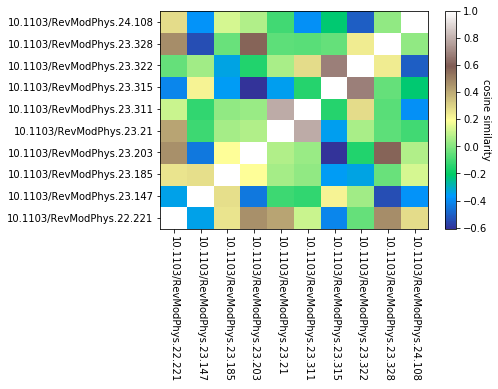

In [179]:
fig, ax = plt.subplots()
hmap = ax.pcolor(heatmapMatrixD, cmap='terrain')
cbar = plt.colorbar(hmap)

cbar.set_label('cosine similarity', rotation=270)
a = ax.set_xticks(np.arange(heatmapMatrixD.shape[1]) + 0.5, minor=False)
a = ax.set_yticks(np.arange(heatmapMatrixD.shape[0]) + 0.5, minor=False)

a = ax.set_xticklabels(targetDocs, minor=False, rotation=270)
a = ax.set_yticklabels(targetDocs, minor=False)

Now let's look at a heatmap of similarities between the first ten documents and our keywords:

In [180]:
heatmapMatrixC = []

for tagOuter in targetDocs:
    column = []
    tagVec = apsD2V.docvecs[tagOuter].reshape(1, -1)
    for tagInner in keywords:
        column.append(sklearn.metrics.pairwise.cosine_similarity(tagVec, apsD2V.docvecs[tagInner].reshape(1, -1))[0][0])
    heatmapMatrixC.append(column)
heatmapMatrixC = np.array(heatmapMatrixC)

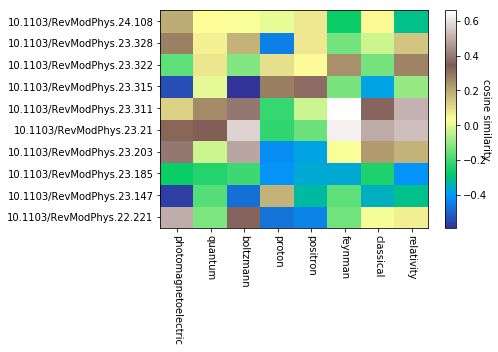

In [181]:
fig, ax = plt.subplots()
hmap = ax.pcolor(heatmapMatrixC, cmap='terrain')
cbar = plt.colorbar(hmap)

cbar.set_label('cosine similarity', rotation=270)
a = ax.set_xticks(np.arange(heatmapMatrixC.shape[1]) + 0.5, minor=False)
a = ax.set_yticks(np.arange(heatmapMatrixC.shape[0]) + 0.5, minor=False)

a = ax.set_xticklabels(keywords, minor=False, rotation=270)
a = ax.set_yticklabels(targetDocs, minor=False)

We will save the model in case we would like to use it again.

In [182]:
apsD2V.save('apsW2V')

We can later load it:

In [183]:
#apsD2V = gensim.models.word2vec.Word2Vec.load('data/apsW2V')

## <span style="color:red">*Exercise 2*</span>

<span style="color:red">Construct cells immediately below this that build a doc2vec model with your corpus. Interrogate document and word relationships in the resulting space. Construct a heatmap that plots the distances between a subset of your documents against each other, and against a set of informative words. Find distances between *every* document in your corpus and a word or query of interest. What do these doc-doc proximities reveal about your corpus? What do these word-doc proximities highlight? Demonstrate and document one reasonable way to select a defensible subset of query-relevant documents for subsequent analysis.

In [185]:
keywords = ['family', 'romance', 'affair', 'business', 'horror', 'superhero', 'war', 'fashion']

In [189]:
plot['tokenized_words'] = plot['plot'].apply(lambda x: nltk.word_tokenize(x))
plot['normalized_words'] = plot['tokenized_words'].apply(lambda x: lucem_illud.normalizeTokens(x, stopwordLst = stopwords, stemmer = None))

In [220]:
taggedDocs = []
for index, row in plot.iterrows():
    docKeywords = [s for s in keywords if s in row['normalized_words']]
    docKeywords.append(row['year'])
    docKeywords.append(row['title'])
    taggedDocs.append(gensim.models.doc2vec.LabeledSentence(words = row['normalized_words'], tags = docKeywords))
plot['TaggedAbstracts'] = taggedDocs

In [221]:
plot[:5]

,id,title,year,plot,tokenized_sents,normalized_sents,tokenized_words,normalized_words,TaggedAbstracts
0,3281207,(Re)Union,2007,(Re)Union uses contemporary dance to examine t...,"[[(, Re, ), Union, uses, contemporary, dance, ...","[[union, uses, contemporary, dance, examine, r...","[(, Re, ), Union, uses, contemporary, dance, t...","[union, uses, contemporary, dance, examine, re...","([union, uses, contemporary, dance, examine, r..."
1,3281368,... Just a Job,2007,"Born into the legacy of blue collar workers, F...","[[Born, into, the, legacy, of, blue, collar, w...","[[born, legacy, blue, collar, workers, fred, n...","[Born, into, the, legacy, of, blue, collar, wo...","[born, legacy, blue, collar, workers, fred, ne...","([born, legacy, blue, collar, workers, fred, n..."
2,3281561,...go I,2007,...go I is a contemporary exploration of a fam...,"[[..., go, I, is, a, contemporary, exploration...","[[go, contemporary, exploration, family, life,...","[..., go, I, is, a, contemporary, exploration,...","[go, contemporary, exploration, family, life, ...","([go, contemporary, exploration, family, life,..."
3,3282030,0506HK,2007,0506HK documents filmmaker Quentin Lee's retur...,"[[0506HK, documents, filmmaker, Quentin, Lee, ...","[[documents, filmmaker, quentin, lee, returns,...","[0506HK, documents, filmmaker, Quentin, Lee, '...","[documents, filmmaker, quentin, lee, returns, ...","([documents, filmmaker, quentin, lee, returns,..."
4,3282343,"1, 2, 3, Whiteout",2007,"In a future present, a rebellious Veronique fi...","[[In, a, future, present, ,, a, rebellious, Ve...","[[future, present, rebellious, veronique, find...","[In, a, future, present, ,, a, rebellious, Ver...","[future, present, rebellious, veronique, finds...","([future, present, rebellious, veronique, find..."


In [238]:
plotD2V = gensim.models.doc2vec.Doc2Vec(plot['TaggedAbstracts'], size = 100) #Limiting to 100 dimensions

In [353]:
plotD2V.save('plotD2V.mm')

In [239]:
plotD2V.most_similar(positive = ['woman','pretty'], negative = ['man'])

[('attracted', 0.7553850412368774),
 ('smart', 0.7470264434814453),
 ('confident', 0.7446215152740479),
 ('flower', 0.7403482794761658),
 ('cute', 0.739296555519104),
 ('duckling', 0.7350632548332214),
 ('attractive', 0.7204179763793945),
 ('aubrey', 0.710843563079834),
 ('personification', 0.7102031707763672),
 ('spoiled', 0.7051250338554382)]

In [240]:
plotD2V.most_similar(positive = ['woman','smart'], negative = ['man'])

[('sexy', 0.7578592300415039),
 ('dating', 0.7286725640296936),
 ('attractive', 0.7217409610748291),
 ('attracted', 0.7175787091255188),
 ('confident', 0.7155389785766602),
 ('intelligent', 0.7089490294456482),
 ('goth', 0.7018779516220093),
 ('cute', 0.7014197111129761),
 ('dress', 0.6968613266944885),
 ('pretty', 0.6935397386550903)]

If woman is "pretty", man is "attracted", and if woman is "smart", man is "sexy" and will "date" woman. It seems that there is no striking difference between the importance of woman's appearance and intelligence in man's pesperctive.

In [242]:
plotD2V.most_similar(positive = ['woman','husband'], negative = ['man'])

[('dido', 0.7515984773635864),
 ('boyfriend', 0.7319185733795166),
 ('unfaithfulness', 0.7068113088607788),
 ('maria', 0.7017094492912292),
 ('anna', 0.6887801289558411),
 ('maid', 0.6884359121322632),
 ('nurse', 0.686508059501648),
 ('eleanor', 0.6857141852378845),
 ('kendall', 0.676490306854248),
 ('pregnancy', 0.6724026203155518)]

"woman" plus "husband" does not equal to "man" plus "wife", instead, it equals to "man" plus "unfaithfulness". This indicates how the image of "wife" has been damaged on screen.

Since we can calculate the distance between a word and documents in the dataset, we can use this method to select a defensible subset of query-relevant documents for subsequent analysis.

In [247]:
# Find documents about weddings
plotD2V.docvecs.most_similar([ plotD2V['wedding'] ], topn=10 )

[('Bachelorette', 0.740663468837738),
 ('Victorious Lola', 0.7400469779968262),
 ('Bridal Jitters', 0.7383280992507935),
 ('She Fell for Him', 0.7316016554832458),
 ('Bad Penny', 0.7296748161315918),
 ('From Beyond the Grave', 0.7266324758529663),
 ('The Care Taker', 0.7227994799613953),
 ('Sarah Landon and the Paranormal Hour', 0.7180745005607605),
 ('Accident', 0.7167636752128601),
 ('Becoming Blond', 0.7132968902587891)]

In [245]:
# Find documents about affair
plotD2V.docvecs.most_similar([ plotD2V['affair'] ], topn=10 )

[('116', 0.6903113126754761),
 ('Forlorn', 0.6853482723236084),
 ('A Crushing Love', 0.660381555557251),
 ('Thrown Down', 0.6528223752975464),
 ('Is She the One?', 0.6441242098808289),
 ('Blood and Chocolate', 0.6433272361755371),
 ("Love's a Bitch, and Then You Die", 0.6422015428543091),
 ('No Snakes in the Garden', 0.6391201615333557),
 ('A Complex Villainelle', 0.6358553171157837),
 ('200 Cartas', 0.6309974193572998)]

In [256]:
# Find documents about wedding and affair
plotD2V.docvecs.most_similar([ plotD2V['wedding']+plotD2V['affair']], topn=10 )

[('A Crushing Love', 0.7305070757865906),
 ('Bridal Jitters', 0.7028250694274902),
 ('Born and Missing', 0.699512779712677),
 ('She Fell for Him', 0.695561945438385),
 ('Tan', 0.6890191435813904),
 ('A Good Funeral', 0.6878024935722351),
 ('The Good Samaritans', 0.6822532415390015),
 ('The Unspeakable Act', 0.6813105344772339),
 ('Christmas Night with Fritz Dubert', 0.6812114715576172),
 ('Becoming Blond', 0.6802348494529724)]

I tried searching these films online and found they are pretty good matches. For example, the top one movie similar to "wedding" "Bachelorette": <img src='Bachelorette.png'>

In [251]:
# Find words most similar to certain documents
plotD2V.most_similar( [ plotD2V.docvecs['Inception'] ], topn=5) 

[('tactic', 0.623603105545044),
 ('cb', 0.5850043296813965),
 ('bellas', 0.5848094820976257),
 ('diaper', 0.5817420482635498),
 ('infestation', 0.556124210357666)]

In [253]:
# A function to plot the heatmap of documents against documents/words
def plot_heatmap(target1, target2, modelD2V):
    heatmapMatrix = []
    for tagOuter in target1:
        column = []
        tagVec = modelD2V.docvecs[tagOuter].reshape(1, -1)
        for tagInner in target2:
            column.append(sklearn.metrics.pairwise.cosine_similarity(tagVec, modelD2V.docvecs[tagInner].reshape(1, -1))[0][0])
        heatmapMatrix.append(column)
    heatmapMatrix = np.array(heatmapMatrix)

    fig, ax = plt.subplots()
    hmap = ax.pcolor(heatmapMatrix, cmap='terrain')
    cbar = plt.colorbar(hmap)

    cbar.set_label('cosine similarity', rotation=270)
    a = ax.set_xticks(np.arange(heatmapMatrix.shape[1]) + 0.5, minor=False)
    a = ax.set_yticks(np.arange(heatmapMatrix.shape[0]) + 0.5, minor=False)

    a = ax.set_xticklabels(target2, minor=False, rotation=270)
    a = ax.set_yticklabels(target1, minor=False)

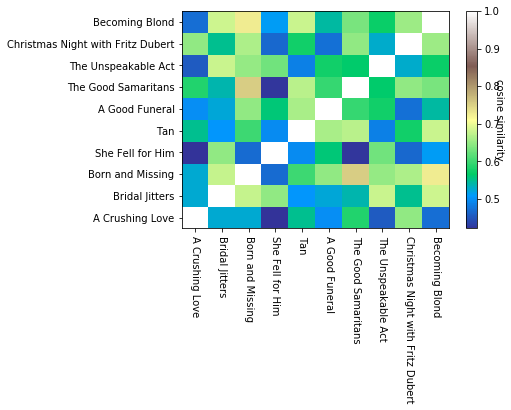

In [257]:
# Plot the distances between a subset of my documents against each other
# Here I plot the top 10 films about "wedding" and "affair" found above
films_wedd_aff = ['A Crushing Love', 'Bridal Jitters', 'Born and Missing', 'She Fell for Him', 'Tan',\
                  'A Good Funeral', 'The Good Samaritans', 'The Unspeakable Act', 'Christmas Night with Fritz Dubert',\
                  'Becoming Blond']
plot_heatmap(films_wedd_aff, films_wedd_aff, plotD2V)

Sadly, I have watched none of these ten movies, but from the heatmap above, we can still get some information about those movies. As we can observe, "She Fell for Him", "A Crushing Love", "A Good Funeral" are the least similar films among the ten, and "The Good Samaritans", "Tan", "Born and Missing" are the most similar ones among the ten. I'm not sure about the reason but I can try to explore it by plotting them against the keywords I have assigned.

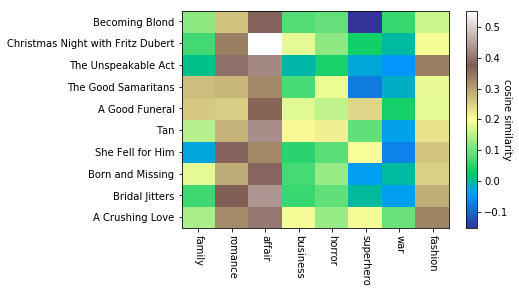

In [259]:
# Plot the distances between a subset of my documents against a set of informative words
# Here I plot the top 10 films about "wedding" and "affair" found above against the keywords
plot_heatmap(films_wedd_aff, keywords, plotD2V)

As we can observe, all of the ten films is similar to films with keyword "affair", which makes sense as they are the top 10 films about "affair" and "wedding" in my dataset. The ten films are also similar to films with keyword "romance" or "fashion", and quite different from films with keyword "superhero" and "war". This indicates that these ten films involved in "wedding" and "affair" is more about woman-man relationship and quite far from themes like "superhero" and "war". We can also observe that the one of the least similar film "She Fell for Him" is very different from "family" and "war" films and similar to "superhero" films, which might partially account for its difference among the ten. And "A Crushing love" and "A Good Funeral" are also similar to "superhero" films, leading to their difference among the ten. However, since the keywords are randomly selected, it might be more informative if I can put more efforts to choose them or use other grouping methods such as genres, etc.

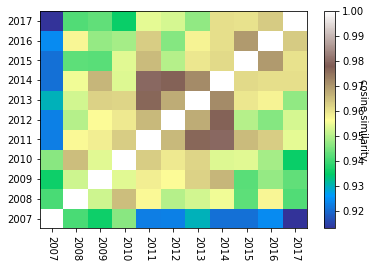

In [264]:
# Plot the distances between documents grouped by year against each other
films_year = list(plot.year.unique())
plot_heatmap(films_year, films_year, plotD2V)

The above heatmap illustrated some information about the evolve of films over time in the past decade. As we can observe, generally speaking, the films are less similar over time and usually similar to films in the preceding year. We can observe a hot spot in the center which implies that films of year 2013 and 2014 are quite similar to those in year 2011 and 2012. We can also observe that films in year 2008 is quite different from those in year 2007, which might be related to the financial crisis in 2008.

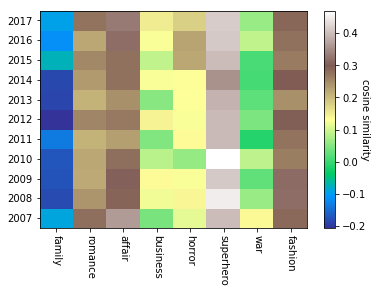

In [265]:
# Plot the distances between documents grouped by year against a set of informative words
plot_heatmap(films_year, keywords, plotD2V)

The above heatmap illustrated the change of topics of films over time. We can observe that among all the films in the last decade, the popular topics of films are "superhero", "fashion", "affair" and "romance", while "family" is not popular at all. From year 2007 to 2008, there are more films about "business" and "superhero" and less films about "family", "romance", "affair" and "war". It might indicates how the desperation from the financial cirsis is reflected in the entertainment that people talk more about "business" and want "superhero" to save them. However, again, it might be more informative to get some other keywords or other grouping methods to illsutrate the depiction of different genders in films.

# Projection

We can also project word vectors to an arbitray semantic dimension. To demonstrate this possibility, let's first load a model trained with New York Times news articles. 

In [266]:
nytimes_model = gensim.models.KeyedVectors.load_word2vec_format('../data/nytimes_cbow.reduced.txt')

First we can visualize with dimension reduction

In [267]:
#words to create dimensions
tnytTargetWords = ['man','him','he', 'woman', 'her', 'she', 'black','blacks','African', 'white', 'whites', 'Caucasian', 'rich', 'richer', 'richest', 'expensive', 'wealthy', 'poor', 'poorer', 'poorest', 'cheap', 'inexpensive']
#words we will be mapping
tnytTargetWords += ["doctor","lawyer","plumber","scientist","hairdresser", "nanny","carpenter","entrepreneur","musician","writer", "banker","poet","nurse", "steak", "bacon", "croissant", "cheesecake", "salad", "cheeseburger", "vegetables", "beer", "wine", "pastry", "basketball", "baseball", "boxing", "softball", "volleyball", "tennis", "golf", "hockey", "soccer"]


wordsSubMatrix = []
for word in tnytTargetWords:
    wordsSubMatrix.append(nytimes_model[word])
wordsSubMatrix = np.array(wordsSubMatrix)
wordsSubMatrix

array([[-0.343139, -0.117117, -0.50773 , ..., -0.995696,  0.921299,
         0.943769],
       [-0.362909, -0.263528,  0.032661, ..., -0.043032, -0.178965,
         0.353556],
       [-0.70167 , -0.344525, -0.320714, ...,  0.009001,  0.11055 ,
         0.751077],
       ...,
       [-2.391626, -1.90143 ,  1.031182, ...,  2.947464,  1.01588 ,
         2.00033 ],
       [-2.432387, -1.161415,  1.060064, ...,  4.402381,  0.500471,
         1.644596],
       [ 0.981931,  0.628094, -0.747547, ...,  1.612927,  1.148063,
         1.063776]], dtype=float32)

In [268]:
pcaWordsNYT = sklearn.decomposition.PCA(n_components = 50).fit(wordsSubMatrix)
reducedPCA_dataNYT = pcaWordsNYT.transform(wordsSubMatrix)
#T-SNE is theoretically better, but you should experiment
tsneWordsNYT = sklearn.manifold.TSNE(n_components = 2).fit_transform(reducedPCA_dataNYT)

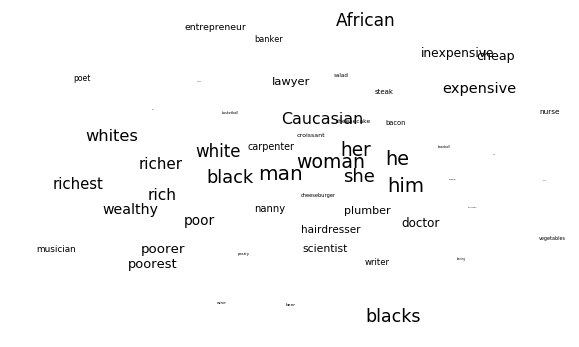

In [269]:
fig = plt.figure(figsize = (10,6))
ax = fig.add_subplot(111)
ax.set_frame_on(False)
plt.scatter(tsneWordsNYT[:, 0], tsneWordsNYT[:, 1], alpha = 0) #Making the points invisible
for i, word in enumerate(tnytTargetWords):
    ax.annotate(word, (tsneWordsNYT[:, 0][i],tsneWordsNYT[:, 1][i]), size =  20 * (len(tnytTargetWords) - i) / len(tnytTargetWords))
plt.xticks(())
plt.yticks(())
plt.show()

Define some convenient functions for getting dimensions. 

In [270]:
def normalize(vector):
    normalized_vector = vector / np.linalg.norm(vector)
    return normalized_vector

def dimension(model, positives, negatives):
    diff = sum([normalize(model[x]) for x in positives]) - sum([normalize(model[y]) for y in negatives])
    return diff

Let's calculate three dimensions: gender, race, and class.

In [271]:
Gender = dimension(nytimes_model, ['man','him','he'], ['woman', 'her', 'she'])
Race = dimension(nytimes_model, ['black','blacks','African'], ['white', 'whites', 'Caucasian'])
Class = dimension(nytimes_model, ['rich', 'richer', 'richest', 'expensive', 'wealthy'], ['poor', 'poorer', 'poorest', 'cheap', 'inexpensive'])

Here we have some words.

In [272]:
Occupations = ["doctor","lawyer","plumber","scientist","hairdresser", "nanny","carpenter","entrepreneur","musician","writer", "banker","poet","nurse"]

Foods = ["steak", "bacon", "croissant", "cheesecake", "salad", "cheeseburger", "vegetables", "beer", "wine", "pastry"]

Sports  = ["basketball", "baseball", "boxing", "softball", "volleyball", "tennis", "golf", "hockey", "soccer"]

Define a function to project words in a word list to each of the three dimensions.

In [273]:
def makeDF(model, word_list):
    g = []
    r = []
    c = []
    for word in word_list:
        g.append(sklearn.metrics.pairwise.cosine_similarity(nytimes_model[word].reshape(1,-1), Gender.reshape(1,-1))[0][0])
        r.append(sklearn.metrics.pairwise.cosine_similarity(nytimes_model[word].reshape(1,-1), Race.reshape(1,-1))[0][0])
        c.append(sklearn.metrics.pairwise.cosine_similarity(nytimes_model[word].reshape(1,-1), Class.reshape(1,-1))[0][0])
    df = pandas.DataFrame({'gender': g, 'race': r, 'class': c}, index = word_list)
    return df

Get the projections.

In [274]:
OCCdf = makeDF(nytimes_model, Occupations) 
Fooddf = makeDF(nytimes_model, Foods)
Sportsdf = makeDF(nytimes_model, Sports)

Define some useful functions for plotting.

In [275]:
def Coloring(Series):
    x = Series.values
    y = x-x.min()
    z = y/y.max()
    c = list(plt.cm.rainbow(z))
    return c

def PlotDimension(ax,df, dim):
    ax.set_frame_on(False)
    ax.set_title(dim, fontsize = 20)
    colors = Coloring(df[dim])
    for i, word in enumerate(df.index):
        ax.annotate(word, (0, df[dim][i]), color = colors[i], alpha = 0.6, fontsize = 12)
    MaxY = df[dim].max()
    MinY = df[dim].min()
    plt.ylim(MinY,MaxY)
    plt.yticks(())
    plt.xticks(())

Plot the occupational words in each of the three dimensions.

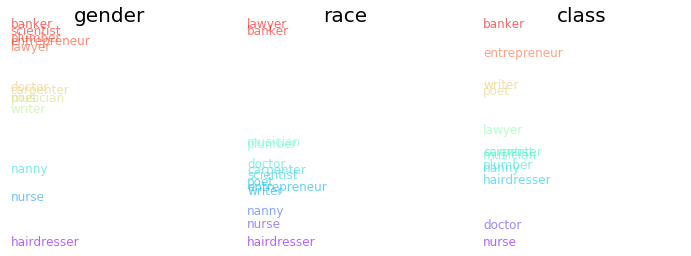

In [276]:
fig = plt.figure(figsize = (12,4))
ax1 = fig.add_subplot(131)
PlotDimension(ax1, OCCdf, 'gender')
ax2 = fig.add_subplot(132)
PlotDimension(ax2, OCCdf, 'race')
ax3 = fig.add_subplot(133)
PlotDimension(ax3, OCCdf, 'class')
plt.show()

Foods:

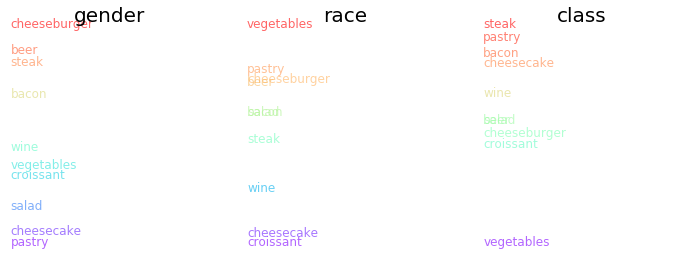

In [277]:
fig = plt.figure(figsize = (12,4))
ax1 = fig.add_subplot(131)
PlotDimension(ax1, Fooddf, 'gender')
ax2 = fig.add_subplot(132)
PlotDimension(ax2, Fooddf, 'race')
ax3 = fig.add_subplot(133)
PlotDimension(ax3, Fooddf, 'class')
plt.show()

Sports:

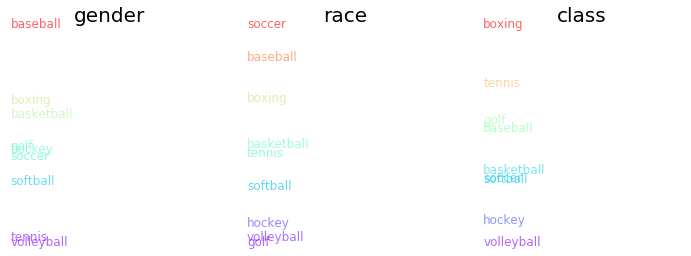

In [278]:
fig = plt.figure(figsize = (12,4))
ax1 = fig.add_subplot(131)
PlotDimension(ax1, Sportsdf, 'gender')
ax2 = fig.add_subplot(132)
PlotDimension(ax2, Sportsdf, 'race')
ax3 = fig.add_subplot(133)
PlotDimension(ax3, Sportsdf, 'class')
plt.show()

## <span style="color:red">*Exercise 3*</span>

<span style="color:red">Construct cells immediately below this that identify semantic dimensions of interest from your data (e.g., gender: man-woman) and project words onto these dimensions. Plot the array of relevant words along each semantic dimension. Which words are most different. Which dimensions are most different? On which dimension are your words most different? Print three short textual examples from the corpus that illustrate the association you have explored.

<span style="color:red">***Stretch***: Project documents from your corpus along a dimension of interest. Sample relevant documents from your corpus with this functionality and explain your rationale? Calculate the cosine of the angle between two dimensions (encoded as vectors) of interest. What does this suggest about the relationship between them within your corpus? 

<span style="color:red">***Stretch***: Create 90% bootstrap confidence intervals around your word projections onto a given dimension. Which words are *significantly* different on your semantic dimension of interest?

In [283]:
# semantic dimensions of interest
Gender = dimension(plotW2V, ['man', 'him', 'he', 'himself'], ['woman', 'her', 'she', 'herself'])
Race = dimension(plotW2V, ['black', 'blacks'], ['white', 'whites'])
Class = dimension(plotW2V, ['rich', 'richer', 'richest', 'expensive', 'wealthy'], ['poor', 'poorer', 'poorest', 'cheap', 'inexpensive'])

In [301]:
# words
Occupation = ["doctor", "lawyer", "plumber", "scientist", "professor", "barber", "hairdresser", "nanny", "carpenter","entrepreneur", "musician", "writer", "banker", "poet", "nurse", "robber", "prostitute", "driver", "singer", "thief"]
Emotion = ['happy', 'excited', 'joy', 'content', 'peaceful', 'motivated', 'sad', 'sorrow', 'grieving', 'bitter', 'depressed', 'frustrated', 'angry', 'annoyed', 'anxious', 'bored', 'determined', 'envious', 'jealous', 'lonely', 'nervous', 'scared']
Power = ['powerful', 'strong', 'control', 'submissive', 'important', 'influential', 'dominant', 'weak', 'gentle', 'obedient', 'kill', 'die']

In [302]:
# Visualize with dimension reduction
plotTargetWords = Occupation + Emotion + Power + ['man','him','he','himself','woman','her','she','herself','black','blacks','white','whites', 'rich', 'richer', 'richest', 'expensive', 'wealthy', 'poor', 'poorer', 'poorest', 'cheap', 'inexpensive']

wordsSubMatrix = []
for word in plotTargetWords:
    wordsSubMatrix.append(plotW2V[word])
wordsSubMatrix = np.array(wordsSubMatrix)
wordsSubMatrix

array([[-8.0500114e-01, -4.4445002e-01,  6.4454114e-01, ...,
         6.2412018e-01, -1.2074210e-01,  3.0290353e-01],
       [-8.9390731e-01, -6.7303628e-01, -3.6833350e-02, ...,
         4.4787154e-01,  1.1570322e-01,  4.6101478e-01],
       [-8.0352575e-02, -1.7411555e-01,  8.1285514e-02, ...,
         1.3722293e-01,  3.5386651e-03,  1.1675708e-01],
       ...,
       [ 2.4206951e-01, -2.9296565e-01,  2.1686901e-01, ...,
        -2.9500006e-02,  2.9461671e-02,  7.5973123e-01],
       [-4.2824149e-03, -5.4595155e-01,  2.7124292e-01, ...,
         2.8383234e-01,  8.0748186e-02,  1.6311997e-01],
       [ 8.0922229e-04, -1.3782658e-01,  5.9653934e-02, ...,
         6.6797122e-02,  5.8024853e-02, -1.7662834e-02]], dtype=float32)

In [303]:
pcaWordsplot = sklearn.decomposition.PCA(n_components = 50).fit(wordsSubMatrix)
reducedPCA_dataplot = pcaWordsplot.transform(wordsSubMatrix)
tsneWordsplot = sklearn.manifold.TSNE(n_components = 2).fit_transform(reducedPCA_dataplot)

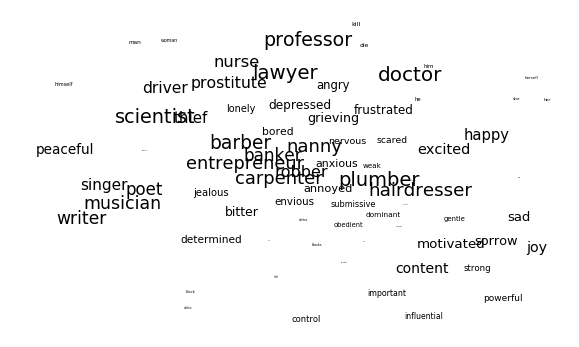

In [304]:
fig = plt.figure(figsize = (10,6))
ax = fig.add_subplot(111)
ax.set_frame_on(False)
plt.scatter(tsneWordsplot[:, 0], tsneWordsplot[:, 1], alpha = 0) #Making the points invisible
for i, word in enumerate(plotTargetWords):
    ax.annotate(word, (tsneWordsplot[:, 0][i],tsneWordsplot[:, 1][i]), size =  20 * (len(plotTargetWords) - i) / len(plotTargetWords))
plt.xticks(())
plt.yticks(())
plt.show()

In [306]:
def makePlotDF(model, word_list):
    g = []
    r = []
    c = []
    for word in word_list:
        g.append(sklearn.metrics.pairwise.cosine_similarity(model[word].reshape(1,-1), Gender.reshape(1,-1))[0][0])
        r.append(sklearn.metrics.pairwise.cosine_similarity(model[word].reshape(1,-1), Race.reshape(1,-1))[0][0])
        c.append(sklearn.metrics.pairwise.cosine_similarity(model[word].reshape(1,-1), Class.reshape(1,-1))[0][0])
    df = pandas.DataFrame({'gender': g, 'race': r, 'class': c}, index = word_list)
    return df

In [307]:
OccDF = makePlotDF(plotW2V, Occupation) 
EmoDF = makePlotDF(plotW2V, Emotion)
PowerDF = makePlotDF(plotW2V, Power)

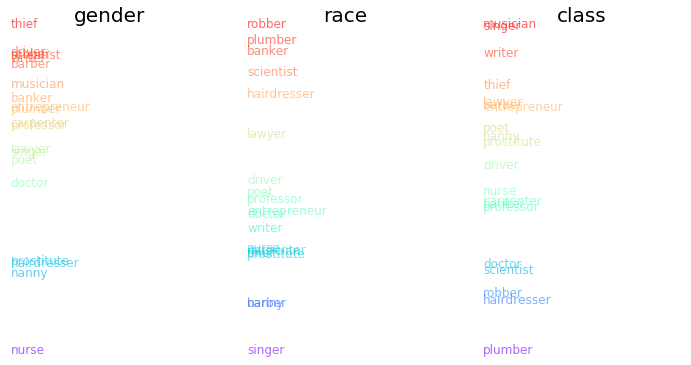

In [311]:
# Plot the occupational words in each of the three dimensions
fig = plt.figure(figsize = (12,6))
ax1 = fig.add_subplot(131)
PlotDimension(ax1, OccDF, 'gender')
ax2 = fig.add_subplot(132)
PlotDimension(ax2, OccDF, 'race')
ax3 = fig.add_subplot(133)
PlotDimension(ax3, OccDF, 'class')
plt.show()

In [316]:
OccDF

,class,gender,race
doctor,0.033479,-0.070042,-0.278344
lawyer,0.288975,-0.020097,-0.215934
plumber,-0.102233,0.038597,-0.142178
scientist,0.025014,0.118586,-0.167376
professor,0.124618,0.015932,-0.266590
barber,0.284814,0.104613,-0.348880
hairdresser,-0.023210,-0.187217,-0.184637
nanny,0.236427,-0.202315,-0.348909
carpenter,0.133322,0.018757,-0.307202
entrepreneur,0.281439,0.042035,-0.276227


In this plot, we can observe that the occupational words are more clustered together on the gender dimension, which indicates that the occupational words are more different on the gender dimension than the other two dimensions. 

Considering the variance of cosine difference within each dimension, the most different dimension is race.

On the gender dimension, "thief", "driver", "scientist", "writer", "barber" are the most masculine jobs and "nurse", "nanny", "prositute", "hairdresser" are the most feminine jobs, thus "thief" and "nurse" are the most different jobs on the gender dimension. On the race dimension, "robber", "plumber", "banker", "scientist" are the most white jobs, and "singer", "nanny", "barber" are the most black jobs, thus "robber" and "singer" are the most different jobs on the race dimension. On the class dimension, "musician", "singer", "writer", "thief", "lawyer", "enterprenuer" are the most wealthy jobs, and "plumber", "hairdresser", "robber" are the most poor jobs, thus "musician" and "plumber" are the most different jobs.

It seems that across three dimensions, "plumber" and "singer" are the most different jobs which are thought to be "masculine", "white", "poor" and "masculine", "black", "wealthy" respectively. We can have a look at a textual example of "plumber" to verify our finding.

In [344]:
plot[plot['plot'].str.contains("plumber")]['plot'].iloc[0]

'Everett Walsh, an over confident handyman, travels to the depths of a creepy sewer after being hired by a kooky cat-lady with a broken sink. Within the sewer, Everett discovers another plumber hired for the same job and Everett must fight to maintain his pride as a "never give up" handyman, while something else lurks in the slimy sewer, besides bickering plumbers.'

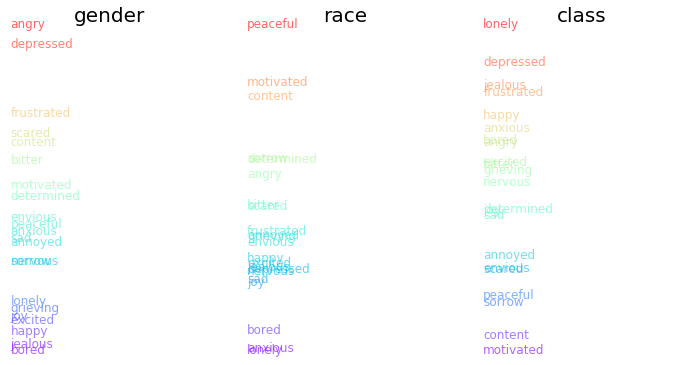

In [312]:
# Plot the emotion-related words in each of the three dimensions
fig = plt.figure(figsize = (12,6))
ax1 = fig.add_subplot(131)
PlotDimension(ax1, EmoDF, 'gender')
ax2 = fig.add_subplot(132)
PlotDimension(ax2, EmoDF, 'race')
ax3 = fig.add_subplot(133)
PlotDimension(ax3, EmoDF, 'class')
plt.show()

In [345]:
EmoDF

,class,gender,race
happy,0.241399,-0.141291,-0.193498
excited,0.137569,-0.133785,-0.200716
joy,0.033387,-0.131726,-0.229047
content,-0.242407,-0.018276,0.052462
peaceful,-0.153667,-0.071580,0.161624
motivated,-0.276699,-0.045781,0.074350
sad,0.020967,-0.080445,-0.224768
sorrow,-0.170007,-0.095457,-0.041454
grieving,0.120030,-0.126312,-0.160245
bitter,0.133174,-0.030049,-0.112071


In this plot, we can observe that the emotion-related words are more clustered together on the race dimensions, which indicates that the emotion-related words are more different on the race dimension than the other two dimensions. 

Considering the variance of cosine difference within each dimension, the most different dimension is class.

On the gender dimension, "angry", "depressed" are the most masculine emotions and "board", "jealous", "happy" are the most feminine emotions, thus "angry" and "board" are the most different emotions on the gender dimension. On the race dimension, "peaceful" is the most white emotion, and "angry", "anxious", "bored" are the most black emotions, thus "peaceful" and "angry" are the most different emotions on the race dimension. On the class dimension, "lonely" is the most wealthy emotion, and "motivated", "content" are the most poor emotions, thus "lonely" and "motivated" are the most different emotions.

It seems that across three dimensions, "angry" is the most different emotion which are thought to be "masculine", "black", and "wealthy". We can have a look at a textual example of "angry" to verify our finding.

In [346]:
plot[plot['plot'].str.contains("angry")]['plot'].iloc[0]

'After Matthew Dragna inherits a rundown old casino from his deceased uncle, Matthew, his loyal girlfriend JJ, and several other friends decide to check the place out. Alas, the casino turns out to be haunted by the lethal and angry ghosts of vicious Las Vegas mobster Roy "The Word" Donahue and his equally pernicious flunky Gil Wachetta. Will Matthew and any of his friends survive a night in the casino with these vengeful spirits?'

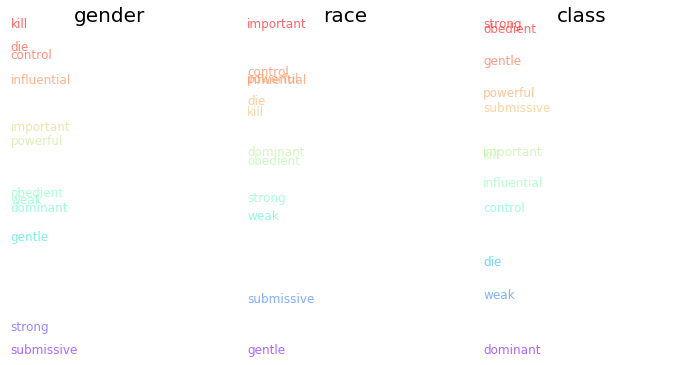

In [314]:
# Plot the power-related words in each of the three dimensions
fig = plt.figure(figsize = (12,6))
ax1 = fig.add_subplot(131)
PlotDimension(ax1, PowerDF, 'gender')
ax2 = fig.add_subplot(132)
PlotDimension(ax2, PowerDF, 'race')
ax3 = fig.add_subplot(133)
PlotDimension(ax3, PowerDF, 'class')
plt.show()

In [347]:
PowerDF

,class,gender,race
powerful,-0.039000,0.024955,0.204237
strong,0.047314,-0.186845,-0.023670
control,-0.182513,0.122006,0.218370
submissive,-0.057339,-0.213085,-0.215914
important,-0.113144,0.040946,0.308854
influential,-0.151810,0.093743,0.201889
dominant,-0.360955,-0.051688,0.065274
weak,-0.291342,-0.042530,-0.057695
gentle,0.000633,-0.084912,-0.313672
obedient,0.040768,-0.034540,0.047834


In this plot, we can observe that the power-related words are more clustered together on the gender dimensions, which indicates that the power-related words are more different on the gender dimension than the other two dimensions. 

Considering the variance of cosine difference within each dimension, the most different dimension is race.

On the gender dimension, "kill", "die", "control" are the most masculine powers and "submissive", "strong" are the most feminine powers, thus "kill" and "submissive" are the most different powers on the gender dimension. On the race dimension, "important" and "gentle" are the most different powers. On the class dimension, "strong", "obedient", "gentle" are the most wealthy powers, and "dominant" is the most poor power, thus "strong" and "dominant" are the most different powers.

It seems that across three dimensions, "strong" is the most different power which are thought to be "feminine", "black", and "wealthy". We can have a look at a textual example of "strong" to verify our finding.

In [348]:
plot[plot['plot'].str.contains("strong")]['plot'].iloc[0]

'n a time, when Islam is under tremendous attack-from within and without-\'A Jihadfor Love\' is a daring documentary-filmed in twelve countries and nine languages. Muslim gay filmmaker Parvez Sharma has gone where the silence is strongest, filming with great risk in nations where government permission to make this film was not an option. A Jihad for Love is the first-ever feature-length documentary to explore the complex global intersections of Islam and homosexuality. With unprecedented access and depth, Sharma brings to light the hidden lives of gay and lesbian Muslims from countries like Iran, Pakistan, Egypt, Turkey, France, India, and South Africa. The majority of gay and lesbian Muslims must travel a lonely and often dangerous road. In many nations with a Muslim majority, laws based on Quranic interpretations are enforced by authorities to monitor, entrap, imprison, torture and even execute homosexuals. Even for those who migrate to Europe or North America and adopt Western perso

Back to my research interest that I mentioned in the beginning, from the projection of three groups of words to gender dimension, we can observe the difference and find the specific female image on screen, which is working as  "nurse", "nanny", "prositute", or "hairdresser", being "board", "jealous", or "happy", and being "submissive" or "strong". There definitely exists some stereotypes that can be explored and analyzed further.